<h1>Análise para identificação de perfis de clientes de uma rede de e-commerce</h1>
<p><b>Instituição:</b> USP ESALQ</p>
<p><b>Ano</b>: 2023</p>
<p><b>Autor:</b> João Paulo Ribeiro dos Santos</p>
<p><b>Localização Projeto: </b> <a href = 'https://github.com/Joao-TheCosmosIsInfinite/Cluster-Analysis' target = "_blank">Git Hub</a></p>

[1. Bibliotecas/ Libs](#1)<br>
[2. Carregar Dados](#2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Analise Pre-liminar](#21)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Relacionamento das Bases](#22)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Dicionário dos Dados](#23)<br>
[3. Informação dos dataframes](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Dimensão](#31)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Dados Generalistas](#31)<br>

%pip install nb-mermaid


%%html
<script src="//cdn.rawgit.com/bollwyvl/53e64cdafba38461943b/raw/0815758d591dfaf0f4918b388aed1bf11d82160d/mermaid.full.js"></script>
<style>
    .mermaid *{font-family: sans-serif; }
    .mermaid .node, .mermaid .cluster{
      fill: white !important;
      stroke: black !important;
      stroke-width: 1px !important;
    }
    .mermaid div{
      text-align: center;
    }
    .mermaid .label{
      color: black;
    }
</style>
<script>$(function(){
    // mermaid load a touch weirdly: try immediately, but try again later if it's not available
    var initMermaid = function(){
        return (window.mermaid && mermaid.init()) || setTimeout(initMermaid, 50);         
    }
    initMermaid();

    // for live editing, re-render only the text of the current cell
    window.IPython && $(IPython.events).on("rendered.MarkdownCell", function(evt, data){
        // this is using a hacked mermaid that accepts some nodes!
        mermaid.init(undefined, data.cell.element.find(".mermaid"));
    });
});</script>

<a id ='1'></a>
<h3>1. Bibliotecas/ Libs</h3>

In [1]:
## Bibliotecas para análise inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
import sys
import os

## Utilidades
from matplotlib.gridspec import GridSpec
from kneed import KneeLocator
sys.path.append(os.path.abspath(os.path.join('..')))
from _functions.funcoes_data_viz import *
from _functions.funcoes_data_wrangling import *

## Bibliotecas de ML
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples, pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from sklearn import metrics

In [2]:
## Definir numero maximo de linhas para visualizar
pd.set_option('display.max_rows', 50)

## Definir numero maximo de linhas para visualizar
pd.set_option('display.max_columns', 50)

<a id ='2'></a>
<h3>2. Carregar Dados</h3>

In [3]:
## Localização dos dados
path = os.path.abspath(os.path.join('..'))

## Objetos/ DataFrames

# Cliente
df_customers = pd.read_csv(path + '/output/olist_customers_dataset.csv')
# Itens de Pedido
df_order_items = pd.read_csv(path + '/output/olist_order_items_dataset.csv')
# Pagamentos de Pedido
df_order_payments = pd.read_csv(path + '/output/olist_order_payments_dataset.csv')
# Pedido
df_orders = pd.read_csv(path + '/output/olist_orders_dataset.csv')
# Produtos
df_products = pd.read_csv(path + '/output/olist_products_dataset.csv')
# Vendedores
df_sellers = pd.read_csv(path + '/output/olist_sellers_dataset.csv')

<a id ='21'></a>
<h4>2.1. Relacionamento das bases</h4>

Relacionamento das tabelas/ datasets

<img src='../img/table_relation.png' width="1000" height="1000">

<a id ='22'></a>
<h4>2.2. Dicionário dos dados</h4>

<h3>Customer</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>
    <tr><td>customer_id</td><td>Identificador único do cliente</td><td>Categórica Nominal</td></tr>
    <tr><td>customer_unique_id</td><td>Identificador único de algum documento do cliente</td><td>Categórica Nominal</td></tr>
    <tr><td>customer_zip_code_prefix</td><td>Código postal</td><td>Categórica Nominal</td></tr>
    <tr><td>customer_city</td><td>Cidade onde reside o cliente</td><td>Categórica Nominal</td></tr>
    <tr><td>customer_state</td><td>Estado onde reside o cliente</td><td>Categórica Nominal</td></tr>
</table>


<h3>Order Items</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>
    <tr><td>order_id</td><td>Identificador único do pedido</td><td>Categórica Nominal</td></tr>
    <tr><td>order_item_id</td><td>Identificador númerico referente ao item no pedido</td><td>Categórica Nominal</td></tr>
    <tr><td>product_id</td><td>Identificador único do produto</td><td>Categórica Nominal</td></tr>
    <tr><td>seller_id</td><td>Identificador único do vendedor</td><td>Categórica Nominal</td></tr>
    <tr><td>shipping_limit_date</td><td>Data limite de entrega</td><td>Numérica Contínua</td></tr>
    <tr><td>price</td><td>Preço do item no pedido</td><td>Numérica Contínua</td></tr>
    <tr><td>freight_value</td><td>Valor do frete cobrado</td><td>Numérica Contínua</td></tr>
</table>


<h3>Order Payments</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>
    <tr><td>order_id</td><td>Identificador único do pedido</td><td>Categórica Nominal</td></tr>
    <tr><td>payment_sequential</td><td>Identificador sequencial único do pagamento</td><td>Categórica Nominal</td></tr>
    <tr><td>payment_type</td><td>Tipo de pagamento</td><td>Categórica Nominal</td></tr>
    <tr><td>payment_installments</td><td>Número de parcelas</td><td>Numérica Discreta</td></tr>
    <tr><td>payment_value</td><td>Valor total do pagamento</td><td>Numérica Contínua</td></tr>
</table>


<h3>Orders</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>
    <tr><td>customer_id</td><td>Identificador único do cliente</td><td>Categórica Nominal</td></tr>
    <tr><td>order_status</td><td>Status do pedido</td><td>Categórica Nominal</td></tr>
    <tr><td>order_purchase_timestamp</td><td>Data de quando o pedido foi feito</td><td>Numérica Contínua</td></tr>
    <tr><td>order_approved_at</td><td>Data de quando o pedido foi aprovado</td><td>Numérica Contínua</td></tr>
    <tr><td>order_delivered_carrier_date</td><td>Data de quando foi entregue a transportadora</td><td>Numérica Contínua</td></tr>
    <tr><td>order_delivered_customer_date</td><td>Data de quando foi entregue ao cliente</td><td>Numérica Contínua</td></tr>
    <tr><td>order_estimated_delivery_date</td><td>Data estimada para entrega</td><td>Numérica Contínua</td></tr>
</table>


<h3>Products</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>    
    <tr><td>product_id</td><td>Identificador único do produto</td><td>Categórica Nominal</td></tr>
    <tr><td>product_category_name</td><td>Categoria do produto</td><td>Categórica Nominal</td></tr>
    <tr><td>product_name_lenght</td><td>Número de caracteres referentes ao nome</td><td>Numérica Discreta</td></tr>
    <tr><td>product_description_lenght</td><td>Número de caracteres referentes a descrição</td><td>Numérica Discreta</td></tr>
    <tr><td>product_photos_qty</td><td>Quantidade de fotos</td><td>Numérica Discreta</td></tr>
    <tr><td>product_weight_g</td><td>Peso em gramas</td><td>Numérica Contínua</td></tr>
    <tr><td>product_length_cm</td><td>Comprimento em centímetros</td><td>Numérica Contínua</td></tr>
    <tr><td>product_height_cm</td><td>Altura em centímetros</td><td>Numérica Contínua</td></tr>
    <tr><td>product_width_cm</td><td>Largura em centímetros</td><td>Numérica Contínua</td></tr>
</table>


<h3>Sellers</h3>
<table>
    <tr><th>Campo</th><th>Descrição</th><th>Tipo de Variável</th></tr>    
    <tr><td>seller_id</td><td>Identificador único do vendedor</td><td>Categórica Nominal</td></tr>
    <tr><td>seller_zip_code_prefix</td><td>Código postal do vendedor</td><td>Categórica Nominal</td></tr>
    <tr><td>seller_city</td><td>Cidade onde o vendedor reside</td><td>Categórica Nominal</td></tr>
    <tr><td>seller_state</td><td>Estado onde o vendedor reside</td><td>Categórica Nominal</td></tr>    
</table>

<a id ='23'></a>
<h4>2.3. Analise Preliminar</h4>

In [4]:
## Cliente
df_customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
## Item de Pedido
df_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [6]:
## Pagamento de Pedido
df_order_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [7]:
## Pedido
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [8]:
## Produtos
df_products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [9]:
## Vendedores
df_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


<a id = '3'></a>
<h3>3. Informação dos dataframes</h3>

<a id ='31'></a>
<h4>3.1. Dimensão</h4>

In [10]:
## Dimensão do dataframe
print('Dimensão do dataframe "df_cutomers":',df_customers.shape)
print('Dimensão do dataframe "df_order_items":', df_order_items.shape)
print('Dimensão do dataframe "df_order_payments":',df_order_payments.shape)
print('Dimensão do dataframe "df_orders":',df_orders.shape)
print('Dimensão do dataframe "df_products":',df_products.shape)
print('Dimensão do dataframe "df_sellers":',df_sellers.shape)

Dimensão do dataframe "df_cutomers": (99441, 5)
Dimensão do dataframe "df_order_items": (112650, 7)
Dimensão do dataframe "df_order_payments": (103886, 5)
Dimensão do dataframe "df_orders": (99441, 8)
Dimensão do dataframe "df_products": (32951, 9)
Dimensão do dataframe "df_sellers": (3095, 4)


<a id ='32'></a>
<h4>3.2. Dados Generalistas</h4>

In [11]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [12]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [13]:
## Converter colunas de data para o tipo datetime
lst_columns = ['shipping_limit_date']
for x in lst_columns:
    df_order_items[x] = df_order_items[x].astype('datetime64[ns]')

In [14]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [15]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [16]:
## Converter colunas de data para o tipo datetime
lst_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for x in lst_columns:
    df_orders[x] = df_orders[x].astype('datetime64[ns]')

In [17]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [18]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [19]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


<a id = '4'></a>
<h3>4. Verificar valores nulos</h3>

In [20]:
## Quantidade de valores nulos por coluna
df_customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [21]:
## Quantidade de valores nulos por coluna
df_order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [22]:
## Quantidade de valores nulos por coluna
df_order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [23]:
## Quantidade de valores nulos por coluna
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [24]:
## Porcentagem de valores nulos por coluna
df_orders.isnull().sum() / len(df_orders) * 100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

In [25]:
## Quantidade de valores nulos por coluna
df_products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [26]:
## Porcentagem de valores nulos por coluna
df_products.isnull().sum() / len(df_orders) * 100

product_id                    0.000000
product_category_name         0.613429
product_name_lenght           0.613429
product_description_lenght    0.613429
product_photos_qty            0.613429
product_weight_g              0.002011
product_length_cm             0.002011
product_height_cm             0.002011
product_width_cm              0.002011
dtype: float64

In [27]:
## Quantidade de valores nulos por coluna
df_sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Foram localizados dados nulos em dois dataframes, isso afeta em demasia tanto as analises exploratórias quanto os próprios modelos de machine learning, todavia, a proporção de dados nulos nos datasets varia 3% a menos de 1%. Tendo em vista que essa quantidade é baixa, os registros que contem esses valores nulos serão removidos da amostra. Essa abordagem foi baseada em um outro estudo utilizando técnicas de clusterização nesse mesmo dataset

<b>Fonte:</b> <br>
CARVALHO, Gabriel Alher. Algoritmos de clusterização e o modelo rfv (recência,
frequência e valor) aplicados em dados de e-commerce. Orientador: Mariana Kleina. 2022. 80 f. TCC (Graduação) – Curso de Engenharia de produção, Setor de tecnologia, Universidade Federal do Paraná, Curitiba, 2020. Disponível em: https://docs.ufpr.br/~marianakleina/TCC17.pdf

In [28]:
## Removendo Valores Nulos
for col in df_orders.columns[df_orders.isna().any()].tolist():
    df_orders = df_orders[pd.notnull(df_orders[col])]
    
## Verificar se ainda existem dados nulos
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


In [29]:
## Removendo Valores Nulos
for col in df_products.columns[df_products.isna().any()].tolist():
    df_products = df_products[pd.notnull(df_products[col])]

## Verificar se ainda existem dados nulos
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


<a id = '5'></a>
<h3>5. Análise Exploratória</h3>

<a id ='51'></a>
<h4>5.1. Analise Univariada</h4>

<a id = '511'></a>
<h5>5.1.1. Dataset df_customers </h5>

In [30]:
## Primeiros 5 Registros
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

As variáveis **customer_id** e **customer_unique_id** são variáveis que identificam um cliente, isto é, são id's. Logo não faz sentido descrevêla em detalhes, o máximo que pode ser feito é avaliar sua quantidade distinta.

In [31]:
print("Quantidade de Linhas: ", len(df_customers))
print("Quantidade Distinta de customer_id: ", df_customers['customer_id'].nunique())
print("Quantidade Distinta de customer_unique_id: ", df_customers['customer_unique_id'].nunique())

Quantidade de Linhas:  99441
Quantidade Distinta de customer_id:  99441
Quantidade Distinta de customer_unique_id:  96096


In [32]:
## Verificando valores duplicados
duplicateRows = df_customers[df_customers.duplicated(['customer_unique_id'])]\
                        .sort_values(by=['customer_unique_id', 'customer_id'])
duplicateRows

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
87012,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,maceio,AL
61403,f530197ea86ced9488a03d055e118ebf,0058f300f57d7b93c477a131a59b36c3,40731,salvador,BA
87414,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,brasilia,DF
...,...,...,...,...,...
88272,09c682ef897935e677a0996cfe2008f3,ff44401d0d8f5b9c54a47374eb48c1b8,13070,campinas,SP
92931,62a2c35611e8757e40fbbcecb3c9b2bd,ff8892f7c26aa0446da53d01b18df463,45972,ibiraja,BA
75057,1ae563fdfa500d150be6578066d83998,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
79859,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Foram identificados valores duplicados no campo customer_unique_id, que é um dos campos que compoe o id do cliente. Não é o campo utilizado no join, portanto não afetará a analise em nada, mas é um bom ponto de atenção, dado que um mesmo cliente pode ter mais de um cadastro na plataforma, pode ser desde um bug até uma característica distinta do negócio.

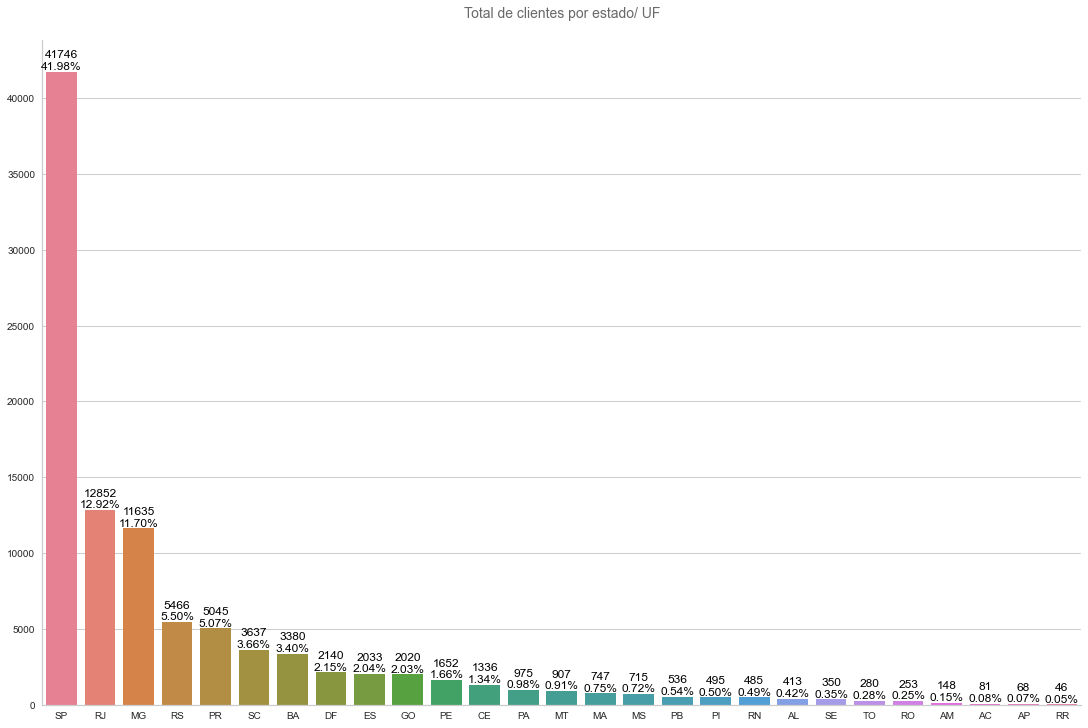

In [33]:
## Total de Clientes por Estado
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_customers, 
               x='customer_state', 
               order=True,
               ax=ax1,
               title='Total de clientes por estado/ UF')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

In [34]:
## Total de clientes por cidade
df_customers['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Cerca de 82% dos clientes são da região Sul e Sudeste e existem os clientes estão bem espalhados entre municipios, embora haja concentração deles nas capitais.

<a id = '512'></a>
<h5>5.1.2. Dataset df_order_items </h5>

In [35]:
## Primeiros 5 Registros
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Essa tabela se refere aos itens de pedido portanto haverão valores duplicados para os dados referentes a **order_id** e **seller_id**, pois um mesmo pedido pode ter mais de um produto, e um mesmo pedido pode ter produtos de um mesmo vendedor.

In [36]:
## Menor data limite de entrega
print ("Menor data limite de entrega: ", df_order_items.shipping_limit_date.min())
## Maior data limite de entrega
print ("Maior data limite de entrega: ", df_order_items.shipping_limit_date.max())

Menor data limite de entrega:  2016-09-19 00:15:34
Maior data limite de entrega:  2020-04-09 22:35:08


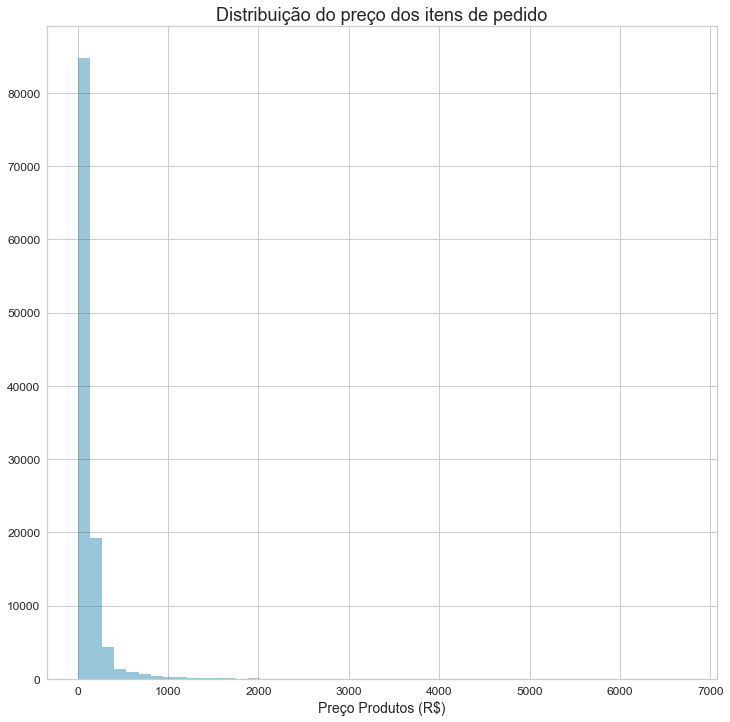

In [37]:
## Tamanho da figura
plt.figure(figsize=(12, 12))

## Objeto referente a distribuição dos dados
ax = sns.distplot(df_order_items['price'],
             kde = False)

## Configuração das fontes dos ticks
ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 12)

## Texto eixo X
plt.xlabel('Preço Produtos (R$)',
           fontsize = 14)

## Titulo
plt.title('Distribuição do preço dos itens de pedido', 
          fontsize = 18)

## Exibir
plt.show()

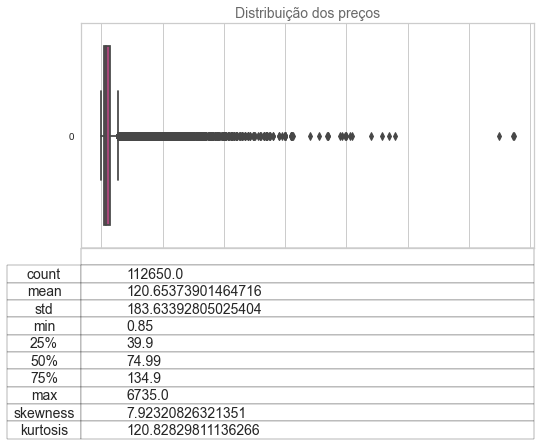

In [38]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_order_items, column='price', ax=ax, title='Distribuição dos preços', palette='magma')

In [39]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_order_items, 'price', 5)

data_bins,price,percent(%)
"(-5.884, 1347.68]",112201,99.601420
"(1347.68, 2694.51]",403,0.357745
"(2694.51, 4041.34]",37,0.032845
"(4041.34, 5388.17]",6,0.005326
"(5388.17, 6735.0]",3,0.002663


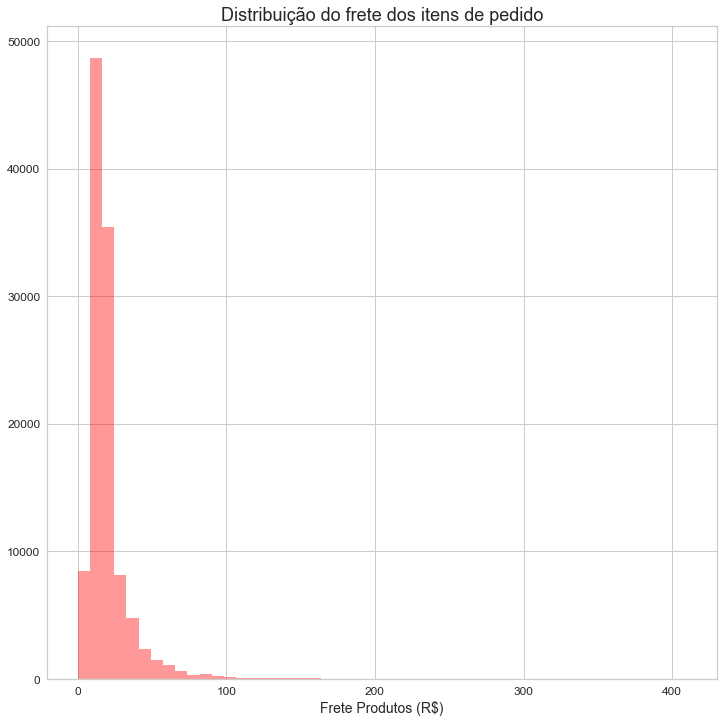

In [40]:
## Tamanho da figura
plt.figure(figsize=(12, 12))

## Objeto referente a distribuição dos dados
ax = sns.distplot(df_order_items['freight_value'], color = 'red',
             kde = False)

## Configuração das fontes dos ticks
ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 12)

## Texto eixo X
plt.xlabel('Frete Produtos (R$)',
           fontsize = 14)

## Titulo
plt.title('Distribuição do frete dos itens de pedido', 
          fontsize = 18)

## Exibir
plt.show()

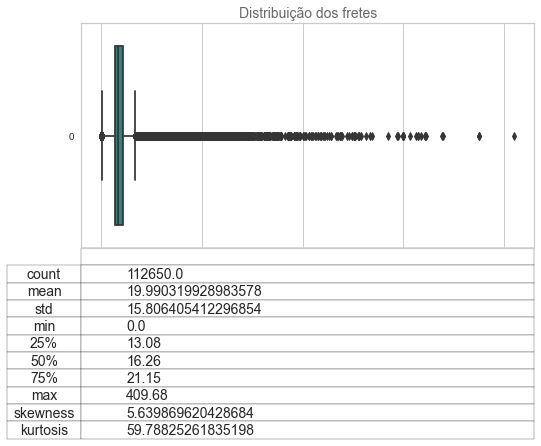

In [41]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_order_items, column='freight_value', ax=ax, title='Distribuição dos fretes')

In [42]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_order_items, 'freight_value', 5)

data_bins,freight_value,percent(%)
"(-0.41, 81.936]",111384,98.876165
"(81.936, 163.872]",1118,0.992455
"(163.872, 245.808]",111,0.098535
"(245.808, 327.744]",32,0.028407
"(327.744, 409.68]",5,0.004439


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

**99.6%** dos itens de pedido estão na faixa _0 até 1347_, indicando que no geral os itens de pedido são baratos, a esmagadora maioria dos produtos comprados são produtos com baixo valor agregado.

Um cenário similar é eoncotrado no frete onde **98.8%** dos fretes pagos estão na faixa _0 até 81_, isso pode estar relacionado ao valor do produto que é barato ou TALVEZ UM PERFIL DE CLIENTE que adquire produtos com frete baixo, ou de vendedores próximos

<a id = '513'></a>
<h5>5.1.3. Dataset df_order_payments </h5>

In [43]:
## Primeiros 5 Registros
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Essa tabela se refere aos pagamentos de pedido portanto haverão valores duplicados para os dados referentes a **order_id** pois um mesmo pedido pode ter mais de uma forma de pagamento.

In [44]:
## Sequencial de pagamento do pedido
df_order_payments.payment_sequential.value_counts()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
18        6
19        6
16        6
17        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64

Como o sequencial de pagamento é bem puverizado em termos de valor, onde temos de 1 tipo de pagamento até 27, que se faz necessario criar categorias para esses sequenciais, facilitando assim as análises

In [45]:
## Pedidos que tiveram MAIS de um tipo de pagamento
condition = df_order_payments[df_order_payments['payment_sequential']>1]['order_id']
## Criar coluna identificando que o pedido teve apenas um tipo de pagamento
df_order_payments['only_1_payment'] = np.where(df_order_payments['order_id'].isin(condition), False, True)

In [46]:
## Estabelecer condicoes para as categorias
conditions = [df_order_payments['only_1_payment'] == True, 
              (df_order_payments['payment_sequential'] <= 5) & (df_order_payments['only_1_payment'] == False), 
              (df_order_payments['payment_sequential'] <= 10) & (df_order_payments['only_1_payment'] == False), 
              (df_order_payments['payment_sequential'] <= 20) & (df_order_payments['only_1_payment'] == False),
              (df_order_payments['payment_sequential'] <= 30) & (df_order_payments['only_1_payment'] == False)]
## Nome das categorias
choices     = [ "apenas_1", "menor_igual_5", 'menor_igual_10', 'menor_igual_20', 'menor_igual_30']
## Coluna com as categorias
df_order_payments["payment_sequential_categ"] = np.select(conditions, choices, default=np.nan)

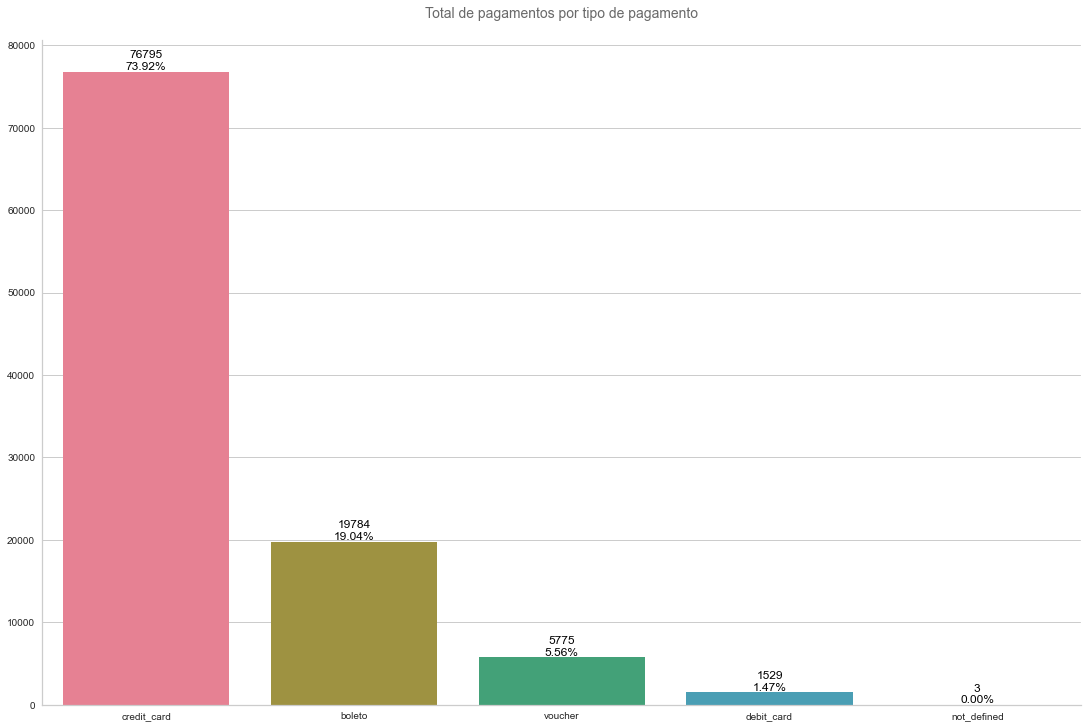

In [47]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_order_payments, 
               x='payment_type', 
               order=True,
               ax=ax1,
               title='Total de pagamentos por tipo de pagamento')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

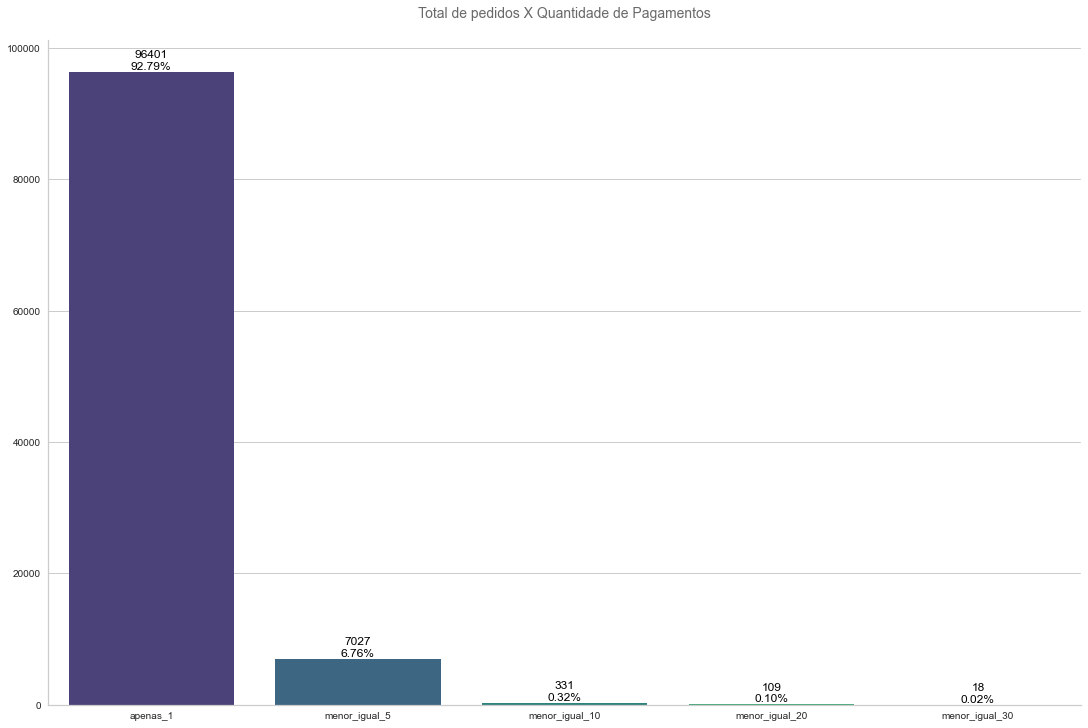

In [48]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_order_payments, 
               x='payment_sequential_categ', 
               order=True,
               palette='viridis',
               ax=ax1,
               title='Total de pedidos X Quantidade de Pagamentos')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

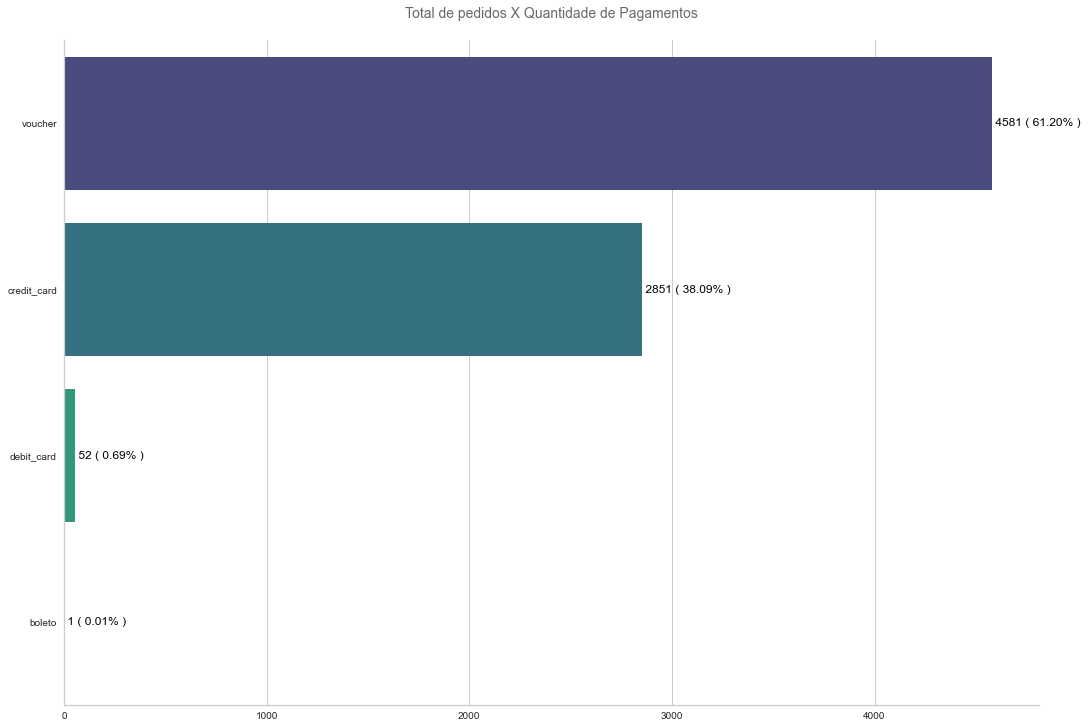

In [49]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_order_payments[df_order_payments['payment_sequential_categ']!= 'apenas_1'], 
               y='payment_type', 
               order=True,
               palette='viridis',
               ax=ax1,
               title='Total de pedidos X Quantidade de Pagamentos')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

Analisando tipos de pagamento x quantidade de pagamentos feitos

In [50]:
df_order_payments.groupby(['payment_sequential_categ','payment_type']).count()['order_id'].reset_index()

,payment_sequential_categ,payment_type,order_id
0,apenas_1,boleto,19783
1,apenas_1,credit_card,73944
2,apenas_1,debit_card,1477
3,apenas_1,not_defined,3
4,apenas_1,voucher,1194
5,menor_igual_10,voucher,331
6,menor_igual_20,voucher,109
7,menor_igual_30,voucher,18
8,menor_igual_5,boleto,1
9,menor_igual_5,credit_card,2851


In [51]:
df_order_payments.groupby(['payment_sequential_categ','payment_type']).count().apply(lambda x: x*100/x.sum())['order_id'].reset_index()

,payment_sequential_categ,payment_type,order_id
0,apenas_1,boleto,19.042989
1,apenas_1,credit_card,71.178022
2,apenas_1,debit_card,1.421751
3,apenas_1,not_defined,0.002888
4,apenas_1,voucher,1.149337
5,menor_igual_10,voucher,0.318618
6,menor_igual_20,voucher,0.104923
7,menor_igual_30,voucher,0.017327
8,menor_igual_5,boleto,0.000963
9,menor_igual_5,credit_card,2.744354


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Cerca de **92%** dos pedidos tem apenas um tipo de pagamento, onde **72%** pagaram com cartão de crédito <br>
Aproximadamente **61%** dos pedidos, que possuem mais de um tipo de pagamento, fazem uso de **Voucher**

In [52]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_order_payments, 'payment_installments', 4)

data_bins,payment_installments,percent(%)
"(-0.024, 6.0]",91679,88.249620
"(6.0, 12.0]",12022,11.572300
"(12.0, 18.0]",145,0.139576
"(18.0, 24.0]",40,0.038504


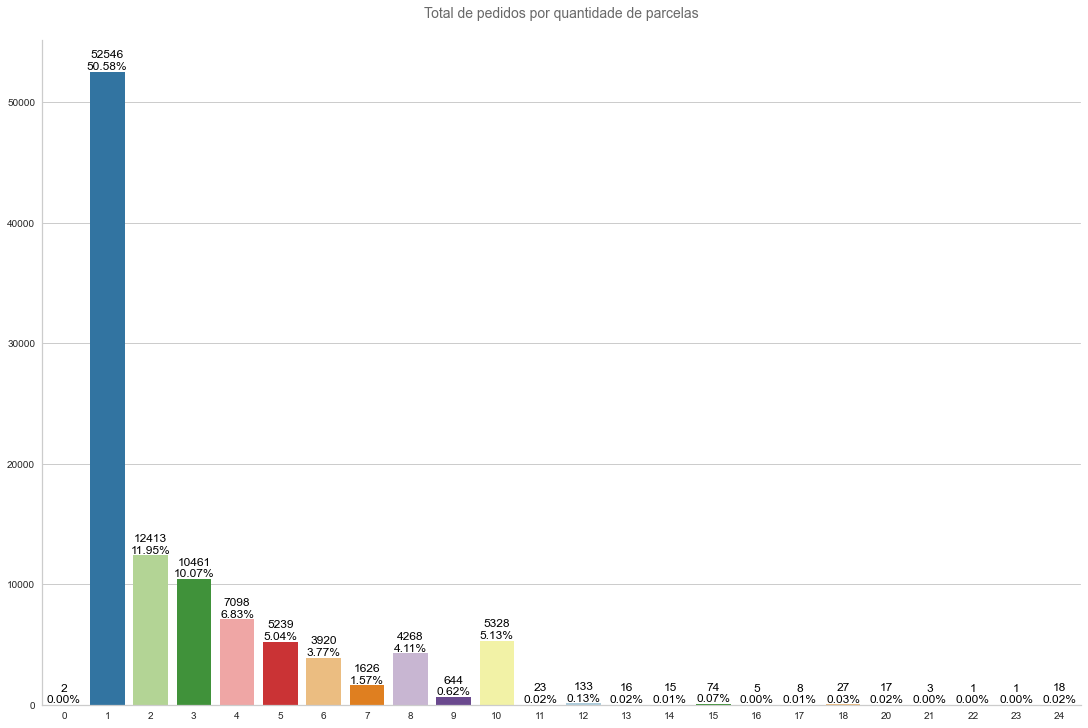

In [53]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_order_payments, 
               x='payment_installments',                
               palette='Paired',
               ax=ax1,
               title='Total de pedidos por quantidade de parcelas')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

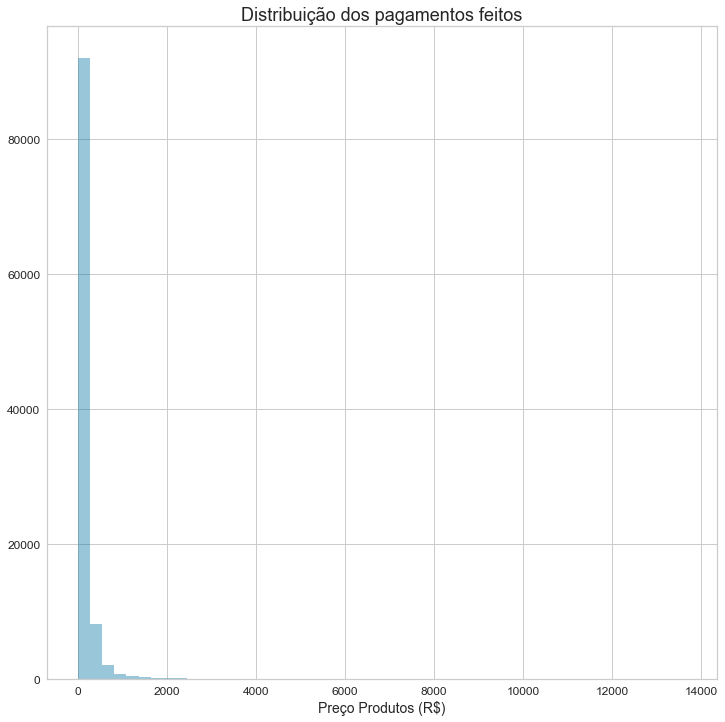

In [54]:
## Tamanho da figura
plt.figure(figsize=(12, 12))

## Objeto referente a distribuição dos dados
ax = sns.distplot(df_order_payments['payment_value'],
             kde = False)

## Configuração das fontes dos ticks
ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 12)

## Texto eixo X
plt.xlabel('Preço Produtos (R$)',
           fontsize = 14)

## Titulo
plt.title('Distribuição dos pagamentos feitos', 
          fontsize = 18)

## Exibir
plt.show()

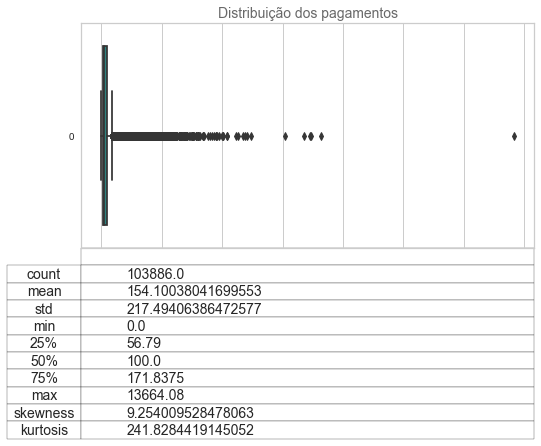

In [55]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_order_payments, column='payment_value', ax=ax, title='Distribuição dos pagamentos', palette='viridis')

In [56]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_order_payments, 'payment_value', 6)

data_bins,payment_value,percent(%)
"(-13.664, 2277.347]",103771,99.889302
"(2277.347, 4554.693]",105,0.101072
"(4554.693, 6832.04]",6,0.005776
"(6832.04, 9109.387]",3,0.002888
"(9109.387, 11386.733]",0,0.000000
"(11386.733, 13664.08]",1,0.000963


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Cerca de **50%** estão associados a pagamentos de apenas 1 parcela.<br>
Mais de **99%** dos pedidos tem entre 1 e 12 parcelas.<br>
**99%** dos pagamentos estão entre 0 e 2277 reais.

<a id = '514'></a>
<h5>5.1.4. Dataset df_orders </h5>

In [57]:
## Primeiros 5 Registros
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [58]:
## Verificando se existem valores duplicados
df_orders[df_orders.duplicated(['order_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [59]:
## Verificando se existem valores duplicados
df_orders[df_orders.duplicated(['customer_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [60]:
## Data do pedido
print ("Menor data: ", df_orders.order_purchase_timestamp.min(), 
       "\nMaior data: ", df_orders.order_purchase_timestamp.max())

Menor data:  2016-09-15 12:16:38 
Maior data:  2018-08-29 15:00:37


In [61]:
## Data de aprovação do pedido
print ("Menor data: ", df_orders.order_approved_at.min(), 
       "\nMaior data: ", df_orders.order_approved_at.max())

Menor data:  2016-09-15 12:16:38 
Maior data:  2018-08-29 15:10:26


In [62]:
## Data de envio a transportadora
print ("Menor data: ", df_orders.order_delivered_carrier_date.min(), 
       "\nMaior data: ", df_orders.order_delivered_carrier_date.max())

Menor data:  2016-10-08 10:34:01 
Maior data:  2018-09-11 19:48:28


In [63]:
## Data estimada de entrega do pedido para o cliente
print ("Menor data: ", df_orders.order_estimated_delivery_date.min(), 
       "\nMaior data: ", df_orders.order_estimated_delivery_date.max())

Menor data:  2016-10-04 00:00:00 
Maior data:  2018-10-25 00:00:00


In [64]:
## Data de entrega do pedido para o cliente
print ("Menor data: ", df_orders.order_delivered_customer_date.min(), 
       "\nMaior data: ", df_orders.order_delivered_customer_date.max())

Menor data:  2016-10-11 13:46:32 
Maior data:  2018-10-17 13:22:46


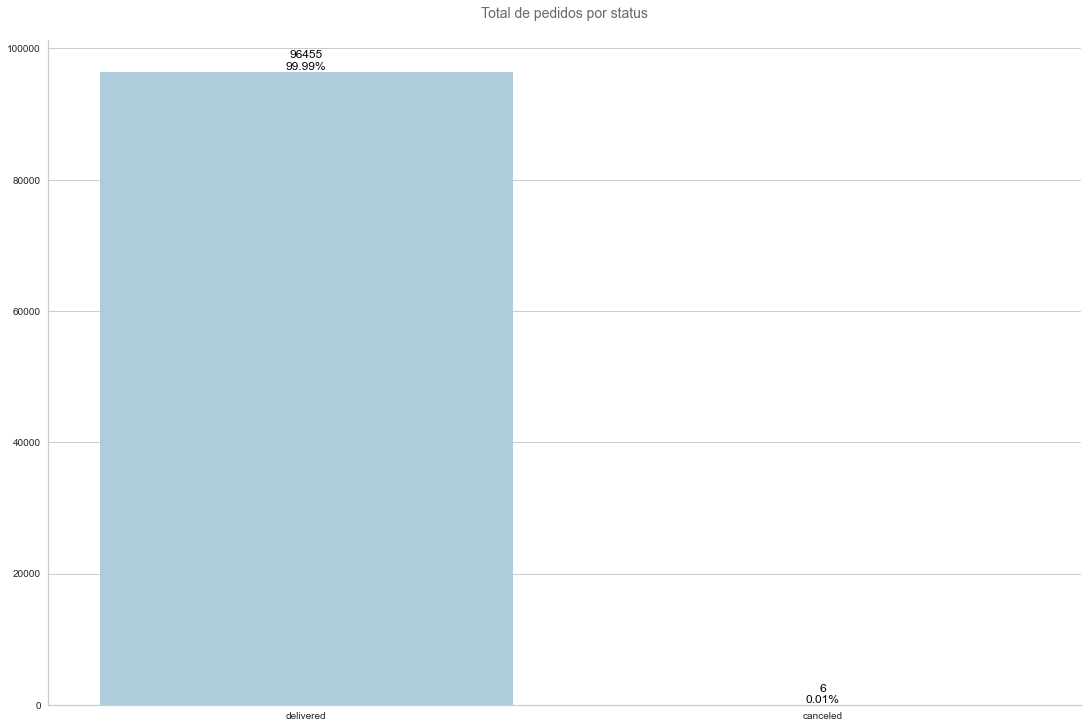

In [65]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_orders, 
               x='order_status',                
               palette='Paired',
               ax=ax1,
               title='Total de pedidos por status')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

Dado os muitos campos referentes a data, que serão criadas novos campos mostrando a diferença dessas datas

In [66]:
## Horas entre compra e aprovação do pedido
df_orders['diff_hours_purchase_approved'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']) / np.timedelta64(1, 'h')
## Horas entre compra e envio para a transportadora
df_orders['diff_hours_carries_purchase'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_purchase_timestamp']) / np.timedelta64(1, 'h')
## Horas entre entrega ao cliente e envio a transportadora
df_orders['diff_hours_customer_carrier'] = (df_orders['order_delivered_customer_date'] - df_orders['order_delivered_carrier_date']) / np.timedelta64(1, 'h')
## Dias entre compra e entrega ao cliente
df_orders['diff_days_customer_purchase'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']) / np.timedelta64(1, 'D')
## Dias entre entrega ao cliente e entrega estimada
df_orders['diff_days_customer_estimated'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date']) / np.timedelta64(1, 'D')

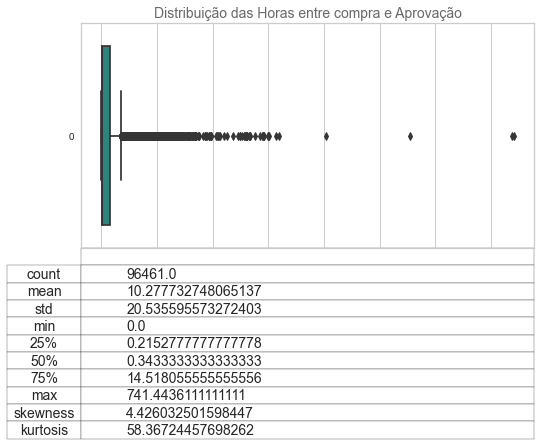

In [67]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_hours_purchase_approved', ax=ax, title='Distribuição das Horas entre compra e Aprovação', palette='viridis')

In [68]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_hours_purchase_approved', 10)

data_bins,diff_hours_purchase_approved,percent(%)
"(-0.741, 74.144]",94384,97.846798
"(74.144, 148.289]",1983,2.055753
"(148.289, 222.433]",54,0.055981
"(222.433, 296.577]",31,0.032137
"(296.577, 370.722]",5,0.005183
"(370.722, 444.866]",1,0.001037
"(444.866, 519.011]",0,0.000000
"(519.011, 593.155]",1,0.001037
"(593.155, 667.299]",0,0.000000
"(667.299, 741.444]",2,0.002073


Analisando o tempo entre a compra do pedido e envio a transportadora

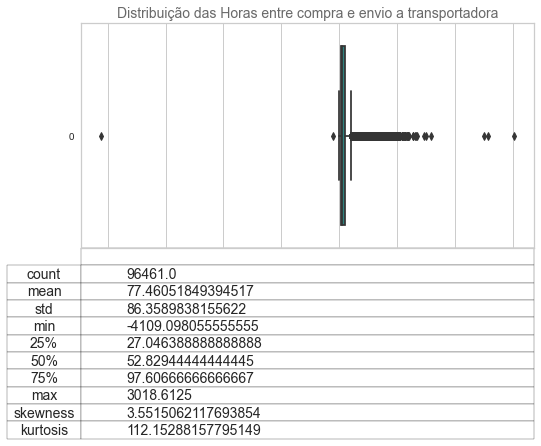

In [69]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_hours_carries_purchase', ax=ax, title='Distribuição das Horas entre compra e envio a transportadora', palette='viridis')

In [70]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_hours_carries_purchase', 10)

data_bins,diff_hours_carries_purchase,percent(%)
"(-4116.226, -3396.327]",1,0.001037
"(-3396.327, -2683.556]",0,0.000000
"(-2683.556, -1970.785]",0,0.000000
"(-1970.785, -1258.014]",0,0.000000
"(-1258.014, -545.243]",0,0.000000
"(-545.243, 167.528]",88419,91.662952
"(167.528, 880.299]",7943,8.234416
"(880.299, 1593.07]",95,0.098485
"(1593.07, 2305.841]",0,0.000000
"(2305.841, 3018.612]",3,0.003110


Foram identificados incongruências, onde temos pedidos cuja data de envio a transportadora é menor do que a data do pedido propriamente dito. Isso não faz o menor sentido, pois o pedido precisa ser feito antes de ser enviado a transportadora. Necessário verificar algum pedido de exemplo

In [71]:
## Verificando pedidos
df_orders[df_orders["diff_hours_carries_purchase"] < 0].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_hours_purchase_approved,diff_hours_carries_purchase,diff_hours_customer_carrier,diff_days_customer_purchase,diff_days_customer_estimated
615,b9afddbdcfadc9a87b41a83271c3e888,85c6af75161b8b2b1af98e82b5a6a5a5,delivered,2018-08-16 13:50:48,2018-08-16 14:05:13,2018-08-16 13:27:00,2018-08-24 14:58:37,2018-09-04,0.240278,-0.396667,193.526944,8.047095,10.375961
1111,ad133696906f6a78826daa0911b7daec,e6f5b234bb0d847f10eebd70130c5d49,delivered,2018-06-15 15:41:22,2018-06-15 16:19:23,2018-06-15 14:52:00,2018-06-22 18:09:37,2018-07-18,0.633611,-0.822778,171.293611,7.102951,25.243322
1329,74e033208dc13a7b8127eb8e73d09b76,72fcbb1145f2889eddcba6d6c1d6c090,delivered,2018-05-02 10:48:44,2018-05-02 11:13:45,2018-05-02 09:49:00,2018-05-07 23:06:36,2018-05-29,0.416944,-0.995556,133.293333,5.512407,21.037083
1372,a6b58794fd2ba533359a76c08df576e3,ccd8e3459ad58ae538c9d2cf35532ba4,delivered,2018-05-14 15:18:23,2018-05-14 15:33:35,2018-05-14 13:46:00,2018-05-19 19:33:32,2018-06-08,0.253333,-1.539722,125.792222,5.177187,19.185046
1864,5792e0b1c8c8a2bf53af468c9a422c88,5c427f06e7fcf902e309743516e2c580,delivered,2018-07-26 13:25:14,2018-07-26 13:35:14,2018-07-26 12:42:00,2018-07-30 14:45:02,2018-08-09,0.166667,-0.720556,98.050556,4.055417,9.385394


In [72]:
print("## Numero de pedidos que foram para a transportadora antes de terem sido lançados: ", len(df_orders[df_orders["diff_hours_carries_purchase"] < 0]))
print("## Numero de pedidos que foram para a transportadora após de terem sido lançados: ", len(df_orders[df_orders["diff_hours_carries_purchase"] >= 0]))

## Numero de pedidos que foram para a transportadora antes de terem sido lançados:  165
## Numero de pedidos que foram para a transportadora após de terem sido lançados:  96296


O número de pedido nesse cenário incomum ,e inferior a 0,2% da amostra, sendo assim tais pedidos serão removidos, pois claramente trata-se de um erro nos dados, oriundo dos mais diversos cenários, desde lançamento errado em algum sistema, ou erro devido a fuso horário

In [73]:
## Estabelecendo condições de remoção
condition = df_orders[df_orders['diff_hours_carries_purchase'] < 0]['order_id']
## Removendo pedidos
df_orders = df_orders[~df_orders['order_id'].isin(condition)]

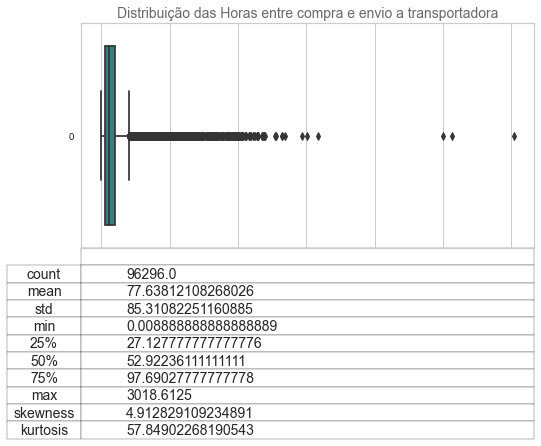

In [74]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_hours_carries_purchase', ax=ax, title='Distribuição das Horas entre compra e envio a transportadora', palette='viridis')

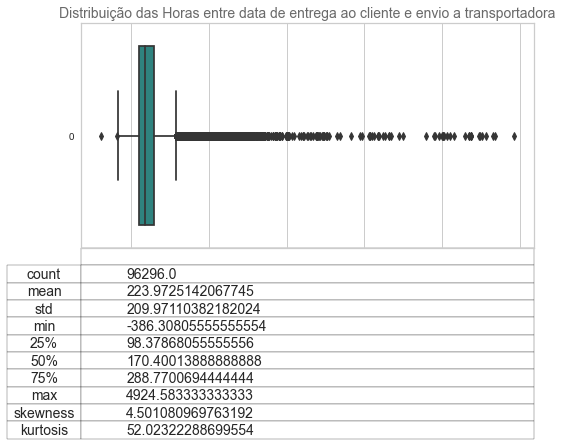

In [75]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_hours_customer_carrier', ax=ax, title='Distribuição das Horas entre data de entrega ao cliente e envio a transportadora', palette='viridis')

In [76]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_hours_customer_carrier', 10)

data_bins,diff_hours_customer_carrier,percent(%)
"(-391.619, 144.781]",37782,39.235275
"(144.781, 675.87]",55279,57.405292
"(675.87, 1206.959]",2816,2.924317
"(1206.959, 1738.048]",309,0.320886
"(1738.048, 2269.138]",45,0.046731
"(2269.138, 2800.227]",23,0.023885
"(2800.227, 3331.316]",15,0.015577
"(3331.316, 3862.405]",4,0.004154
"(3862.405, 4393.494]",16,0.016615
"(4393.494, 4924.583]",7,0.007269


In [77]:
print("## Numero de pedidos que foram para o cliente antes de terem ido para a transportadora: ", len(df_orders[df_orders["diff_hours_customer_carrier"] < 0]))
print("## Numero de pedidos que foram para o cliente após de terem ido para a transportadora: ", len(df_orders[df_orders["diff_hours_customer_carrier"] >= 0]))

## Numero de pedidos que foram para o cliente antes de terem ido para a transportadora:  23
## Numero de pedidos que foram para o cliente após de terem ido para a transportadora:  96273


Outro cenário de divergencia de datas.

Será aplicado o mesmo tratamento

In [78]:
## Estabelecendo condições de remoção
condition = df_orders[df_orders['diff_hours_customer_carrier'] < 0]['order_id']
## Removendo pedidos
df_orders = df_orders[~df_orders['order_id'].isin(condition)]

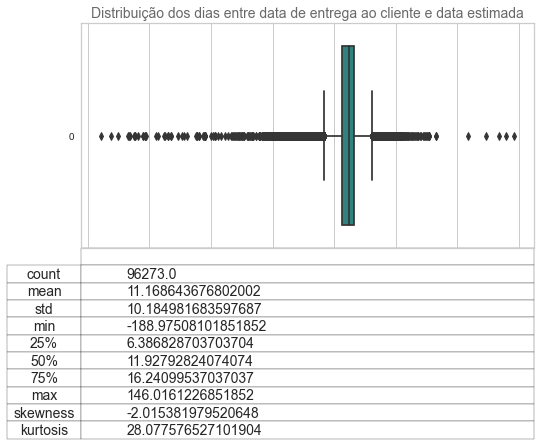

In [79]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_days_customer_estimated', ax=ax, title='Distribuição dos dias entre data de entrega ao cliente e data estimada', palette='viridis')

In [80]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_days_customer_estimated', 10)

data_bins,diff_days_customer_estimated,percent(%)
"(-189.31, -155.476]",11,0.011426
"(-155.476, -121.977]",14,0.014542
"(-121.977, -88.478]",23,0.023890
"(-88.478, -54.979]",51,0.052974
"(-54.979, -21.479]",687,0.713596
"(-21.479, 12.02]",47703,49.549718
"(12.02, 45.519]",47577,49.418840
"(45.519, 79.018]",200,0.207743
"(79.018, 112.517]",3,0.003116
"(112.517, 146.016]",4,0.004155


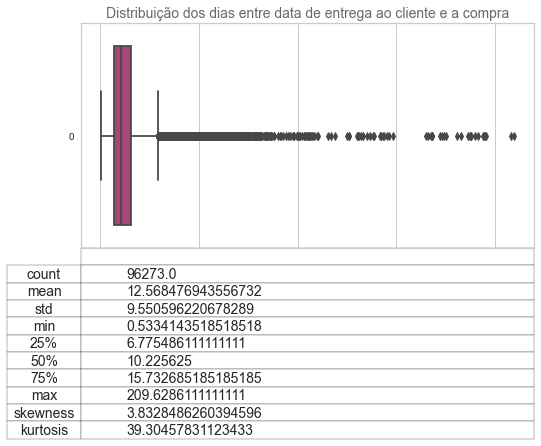

In [81]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_days_customer_purchase', ax=ax, title='Distribuição dos dias entre data de entrega ao cliente e a compra', palette='magma')

In [82]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_days_customer_purchase', 10)

data_bins,diff_days_customer_purchase,percent(%)
"(0.324, 21.443]",84573,87.847060
"(21.443, 42.352]",10309,10.708091
"(42.352, 63.262]",1135,1.178939
"(63.262, 84.171]",164,0.170349
"(84.171, 105.081]",36,0.037394
"(105.081, 125.991]",14,0.014542
"(125.991, 146.9]",17,0.017658
"(146.9, 167.81]",4,0.004155
"(167.81, 188.719]",13,0.013503
"(188.719, 209.629]",8,0.008310


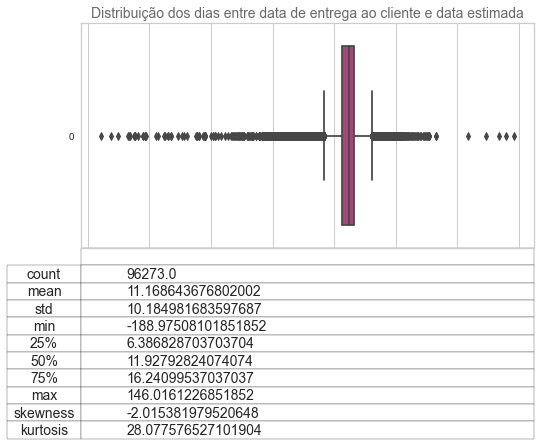

In [83]:
# Chamando a funcao para fazer a plotagem
fig, ax = plt.subplots(figsize=(9, 4))
boxplot(df_orders, column='diff_days_customer_estimated', ax=ax, title='Distribuição dos dias entre data de entrega ao cliente e data estimada', palette='magma')

In [84]:
## Verificar a distribuição dos dados em faixas
data_bin_cut(df_orders, 'diff_days_customer_estimated', 10)

data_bins,diff_days_customer_estimated,percent(%)
"(-189.31, -155.476]",11,0.011426
"(-155.476, -121.977]",14,0.014542
"(-121.977, -88.478]",23,0.023890
"(-88.478, -54.979]",51,0.052974
"(-54.979, -21.479]",687,0.713596
"(-21.479, 12.02]",47703,49.549718
"(12.02, 45.519]",47577,49.418840
"(45.519, 79.018]",200,0.207743
"(79.018, 112.517]",3,0.003116
"(112.517, 146.016]",4,0.004155


In [85]:
print("## Numero de pedidos cujo estimado foi menor do que a data real de entrega: ", len(df_orders[df_orders["diff_days_customer_estimated"] < 0]))
print("## Numero de pedidos foram entregues antes do projetado: ", len(df_orders[df_orders["diff_days_customer_estimated"] >= 0]))

## Numero de pedidos cujo estimado foi menor do que a data real de entrega:  7823
## Numero de pedidos foram entregues antes do projetado:  88450


<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Mais de **8%** dos pedidos foram entregues com atraso.<br>
O tempo médio entre a entrega do pedido e sua criação é de **12 dias**, sendo que em **87%** dos casos os pedidos foram entregues antes de **22 dias**.<br>
Em **97%** dos casos os pedidos demoram até **75 horas** para serem aprovados.<br>
Após a criação do pedido, demora-se em média **77 horas** para seu respectivo envio à transportadora


<a id = '515'></a>
<h5>5.1.5. Dataset df_products </h5>

In [86]:
## Primeiros 5 Registros
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [87]:
## Verificando se há valores duplicados
duplicateRows = df_products[df_products.duplicated(['product_id'])]
duplicateRows

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


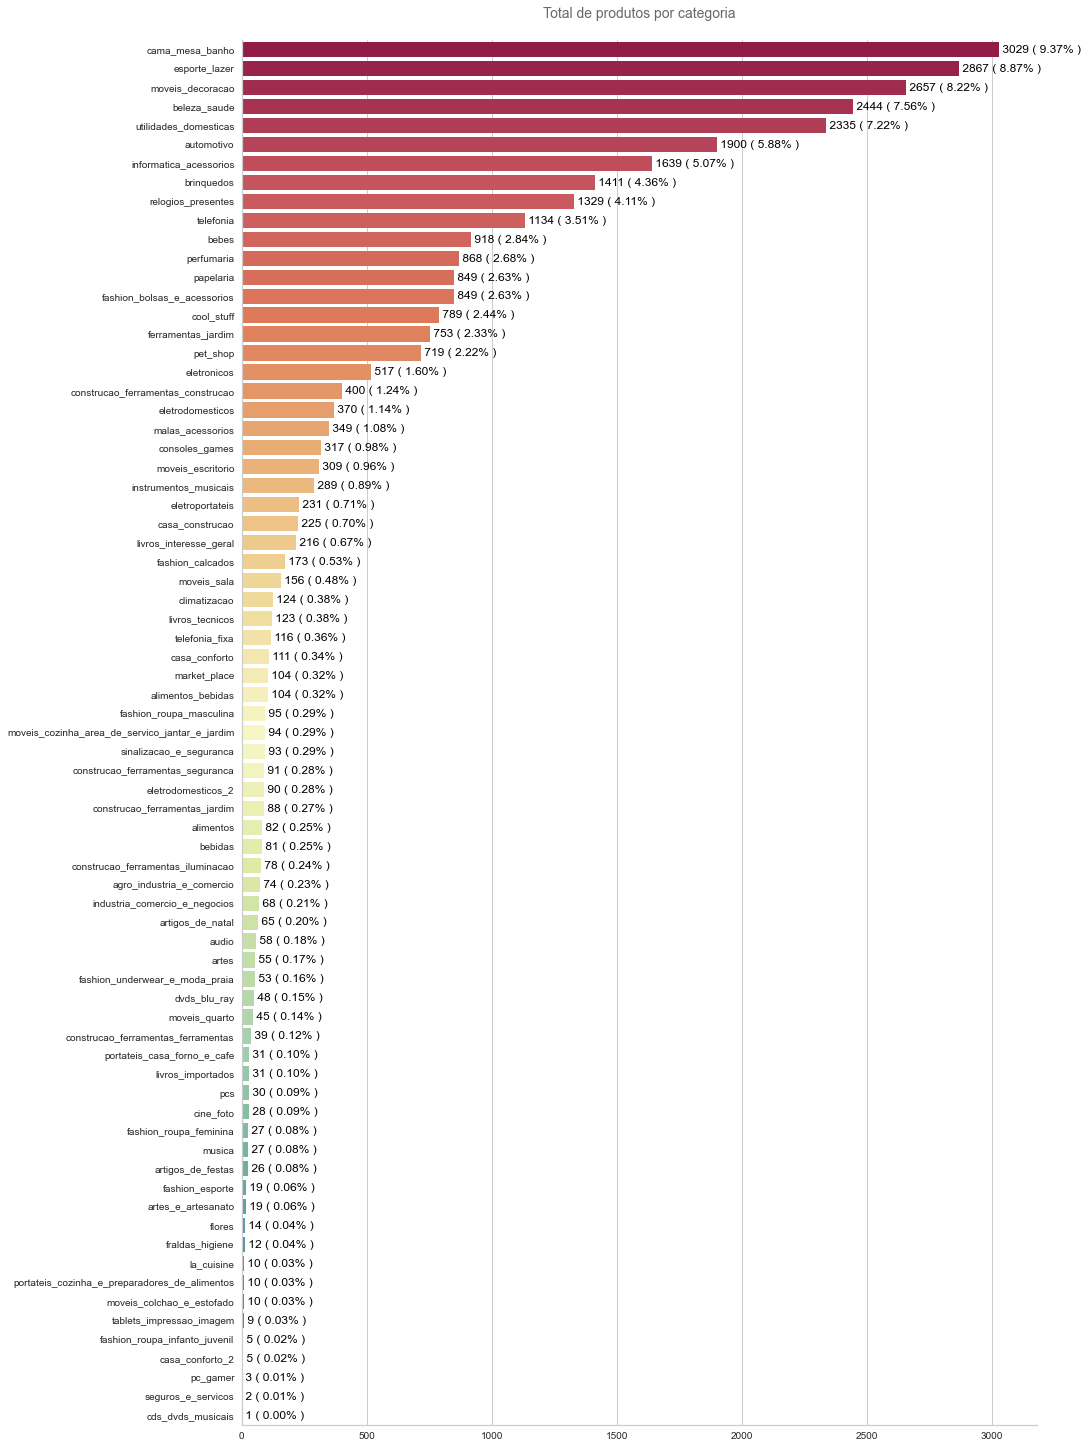

In [88]:
## Total de pagamentos por tipo de pagamento
fig = plt.figure(constrained_layout=True, figsize=(15, 20))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_products, 
               y='product_category_name', 
               order=True,
               palette='Spectral',
               ax=ax1,
               title='Total de produtos por categoria')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

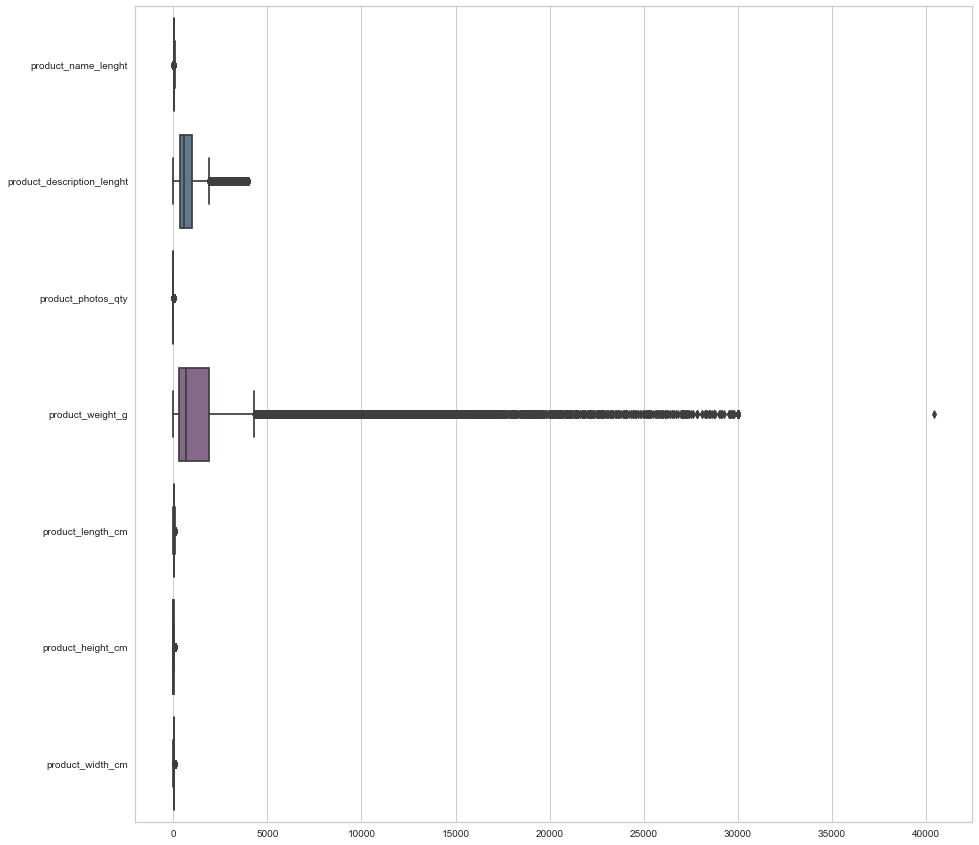

In [89]:
## Tamanho da figura
plt.figure(figsize = (15,15))

## Paleta de cores
sns_my_palete_01 = sns.color_palette('Set1', 
                                     n_colors = 8,
                                     desat = 0.5)

## Criação do objeto referente a plotagem
ax = sns.boxplot(data = df_products[["product_name_lenght", "product_description_lenght", "product_photos_qty", 
                                     "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]],
                 orient='h',
                 palette = sns_my_palete_01 )

## Exibir gráfico
plt.show()

<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

É possível identificar outiliers nesses dados, mas todos eles fazem sentido, por que a loja tem uma variedade imensa de produtos, desde canetas até geladeiras.

<a id = '516'></a>
<h5>5.1.6. Dataset df_sellers </h5>

In [90]:
## Primeiros 5 Registros
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [91]:
## Verificando se há valores duplicados
duplicateRows = df_sellers[df_sellers.duplicated(['seller_id'])]
duplicateRows

,seller_id,seller_zip_code_prefix,seller_city,seller_state


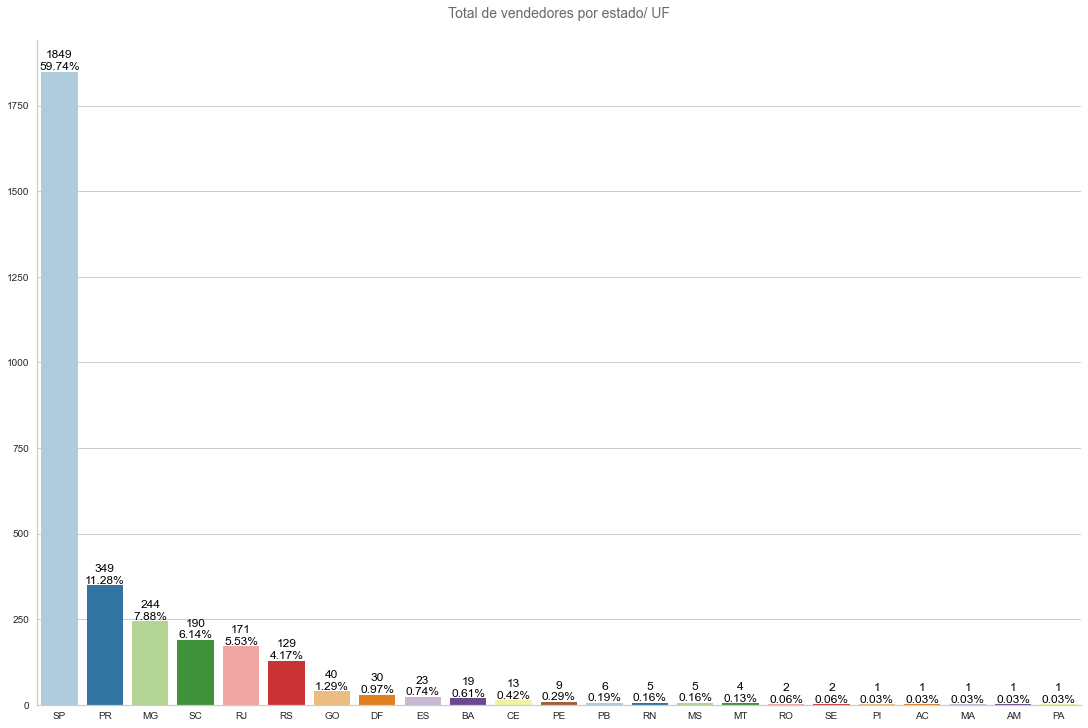

In [92]:
## Total de Clientes por Estado
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

bar_count_plot(df_sellers, 
               x='seller_state', 
               order=True,
               ax=ax1,
               palette='Paired',
               title='Total de vendedores por estado/ UF')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.show()

<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Cerca de **89%** dos vendedores são das regiões Sul e Sudeste

<a id ='52'></a>
<h4>5.2. Junções/ Joins de bases</h4>

Antes de realizar o JOIN é preciso ajustar alguns datasets que possuem _"códigos duplicados"_ onde será feito um agrupamento e aplicação de pivot. Assim teremos tabelas com valores unicos e agrupados onde for necessário

<a id = '521'></a>
<h5>5.2.1. Dataset df_order_payments </h5>

In [93]:
## Analisando os 5 primeiros registros
df_order_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,only_1_payment,payment_sequential_categ
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,True,apenas_1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,True,apenas_1
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,True,apenas_1
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,True,apenas_1
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,True,apenas_1


In [94]:
## Realizando o pivoteamento
df_order_payment_adjusted = pd.pivot_table(df_order_payments, index=["order_id"], 
                                           columns=["payment_type"], 
                                           values=["payment_value"],
                                           aggfunc=np.sum, 
                                           fill_value=0) \
                              .reset_index() \
                              .droplevel(0, axis=1) 

## Renomeando as colunas
df_order_payment_adjusted = df_order_payment_adjusted.rename(columns={'': 'order_id', 
                                                                      'boleto': 'payment_type_boleto',
                                                                      'credit_card': 'payment_type_credit_card',
                                                                      'debit_card': 'payment_type_debit_card',
                                                                      'not_defined': 'payment_type_not_defined',
                                                                      'voucher': 'payment_type_voucher',})

## Incluindo as colunas anteriores
df_aux = df_order_payments.groupby(['order_id']).agg({'payment_installments': 'max', 'payment_sequential': 'max'}).reset_index()
df_order_payment_adjusted = df_order_payment_adjusted.merge(df_aux, on='order_id',how='inner')

## Estabelecer condicoes para as categorias
conditions = [(df_order_payment_adjusted['payment_sequential'] == 1), 
              (df_order_payment_adjusted['payment_sequential'] > 1)]
## Nome das categorias
choices     = [ "apenas_1", "maior_de_1"]
## Coluna com as categorias
df_order_payment_adjusted["payment_sequential_categ"] = np.select(conditions, choices, default=np.nan)

In [95]:
## Analisando os 5 primeiros registros
df_order_payment_adjusted.head(5)

,order_id,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,payment_installments,payment_sequential,payment_sequential_categ
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,72.19,0.0,0,0.0,2,1,apenas_1
1,00018f77f2f0320c557190d7a144bdd3,0.0,259.83,0.0,0,0.0,3,1,apenas_1
2,000229ec398224ef6ca0657da4fc703e,0.0,216.87,0.0,0,0.0,5,1,apenas_1
3,00024acbcdf0a6daa1e931b038114c75,0.0,25.78,0.0,0,0.0,2,1,apenas_1
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.0,218.04,0.0,0,0.0,3,1,apenas_1


<a id = '522'></a>
<h5>5.2.1. Dataset df_order_items </h5>

In [96]:
## Analisando os 5 primeiros registros
df_order_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [97]:
## Realizando o agrupamento
df_order_items_adjusted = df_order_items.groupby(['order_id']).agg({'order_item_id': 'max', 
                                                                    'product_id': 'nunique',
                                                                    'seller_id': 'nunique',
                                                                    'price': 'sum',
                                                                    'freight_value': 'sum'}) \
                                                              .reset_index()

## Renomeando as colunas
df_order_items_adjusted = df_order_items_adjusted.rename(columns={'order_item_id': 'count_order_item_id',
                                                                  'product_id': 'count_product_id',
                                                                  'seller_id': 'count_seller_id',
                                                                  'price': 'total_price',
                                                                  'freight_value': 'total_freight_value',})

In [98]:
## Analisando os 5 primeiros registros
df_order_items_adjusted.head(5)

,order_id,count_order_item_id,count_product_id,count_seller_id,total_price,total_freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,1,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,1,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,1,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,1,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1,1,199.90,18.14


Ajustes concluídos copm sucesso, com isso podemos fazer o join dos datasets e realizar análises multivariadas, e ao mesmo tempo inputar os dados ao modelo.

<a id = '523'></a>
<h5>5.2.3. Criando ABT (Analytical Base Table)</h5>

<p style="font-size: 2rem; color: #F08080">NOTA !!!</p>

Nas análises feitas até aqui, foram identificadas bases de dados que nesse primeiro momento não fazem sentido estar na análise e nos modelos, portanto trabalharemos apenas com as bases relacionadas a **pedido/ orders**, **cliente/ customers**, **item de pedido/ order items** e **pagamento/ payments**

In [99]:
## Realizando join
df_data = df_customers.merge(df_orders, on='customer_id',how='inner') \
                      .merge(df_order_payment_adjusted, on='order_id',how='inner') \
                      .merge(df_order_items_adjusted, on='order_id',how='inner') 

In [100]:
## Removendo colunas desnecessárias
df_data = df_data.drop(['customer_zip_code_prefix'], axis=1)

## Criando coluna com todos os pagamentos
df_data["total_payment"] = df_data["payment_type_boleto"] \
                            + df_data["payment_type_credit_card"] \
                            + df_data["payment_type_debit_card"] \
                            + df_data["payment_type_not_defined"] \
                            + df_data["payment_type_voucher"]

In [101]:
## Primeiros registros
df_data.head(3)

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_hours_purchase_approved,diff_hours_carries_purchase,diff_hours_customer_carrier,diff_days_customer_purchase,diff_days_customer_estimated,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,payment_installments,payment_sequential,payment_sequential_categ,count_order_item_id,count_product_id,count_seller_id,total_price,total_freight_value,total_payment
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,0.276944,163.706111,47.793889,8.812500,10.558623,0.0,146.87,0.0,0,0.0,2,1,apenas_1,1,1,1,124.99,21.88,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,0.168889,68.443056,331.438889,16.661748,7.471308,0.0,335.48,0.0,0,0.0,8,1,apenas_1,1,1,1,289.00,46.48,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,24.190278,550.387500,75.464167,26.077153,-1.749201,0.0,157.73,0.0,0,0.0,7,1,apenas_1,1,1,1,139.94,17.79,157.73


<a id ='53'></a>
<h4>5.3. Análise dos dados qualitativos</h4>

<a id ='531'></a>
<h5>5.3.1 Distribuição de Frequência</h5>

In [102]:
## Distribuição de frequência
frequency_distribution(df_data, 'customer_state')

,Frequencia Absoluta,Frequencia Relativa
customer_state,,
SP,40422,41.987286
RJ,12331,12.808501
MG,11325,11.763545
RS,5325,5.531203
PR,4912,5.102210
SC,3535,3.671888
BA,3252,3.377929
DF,2077,2.157429
ES,1989,2.066021


In [103]:
## Distribuição de frequência
frequency_distribution(df_data, 'customer_city').head(5)

,Frequencia Absoluta,Frequencia Relativa
customer_city,,
sao paulo,15019,15.600590
rio de janeiro,6594,6.849344
belo horizonte,2687,2.791050
brasilia,2068,2.148080
curitiba,1486,1.543543


In [104]:
## Distribuição de frequência
frequency_distribution(df_data, 'order_status').head(5)

,Frequencia Absoluta,Frequencia Relativa
order_status,,
delivered,96266,99.993768
canceled,6,0.006232


In [105]:
## Distribuição de frequência
frequency_distribution(df_data, 'payment_sequential_categ').head(5)

,Frequencia Absoluta,Frequencia Relativa
payment_sequential_categ,,
apenas_1,93325,96.938882
maior_de_1,2947,3.061118


<a id ='54'></a>
<h4>5.4. Análise dos dados quantitativos</h4>

<a id ='541'></a>
<h5>5.4.1 Boxplot Geral</h5>

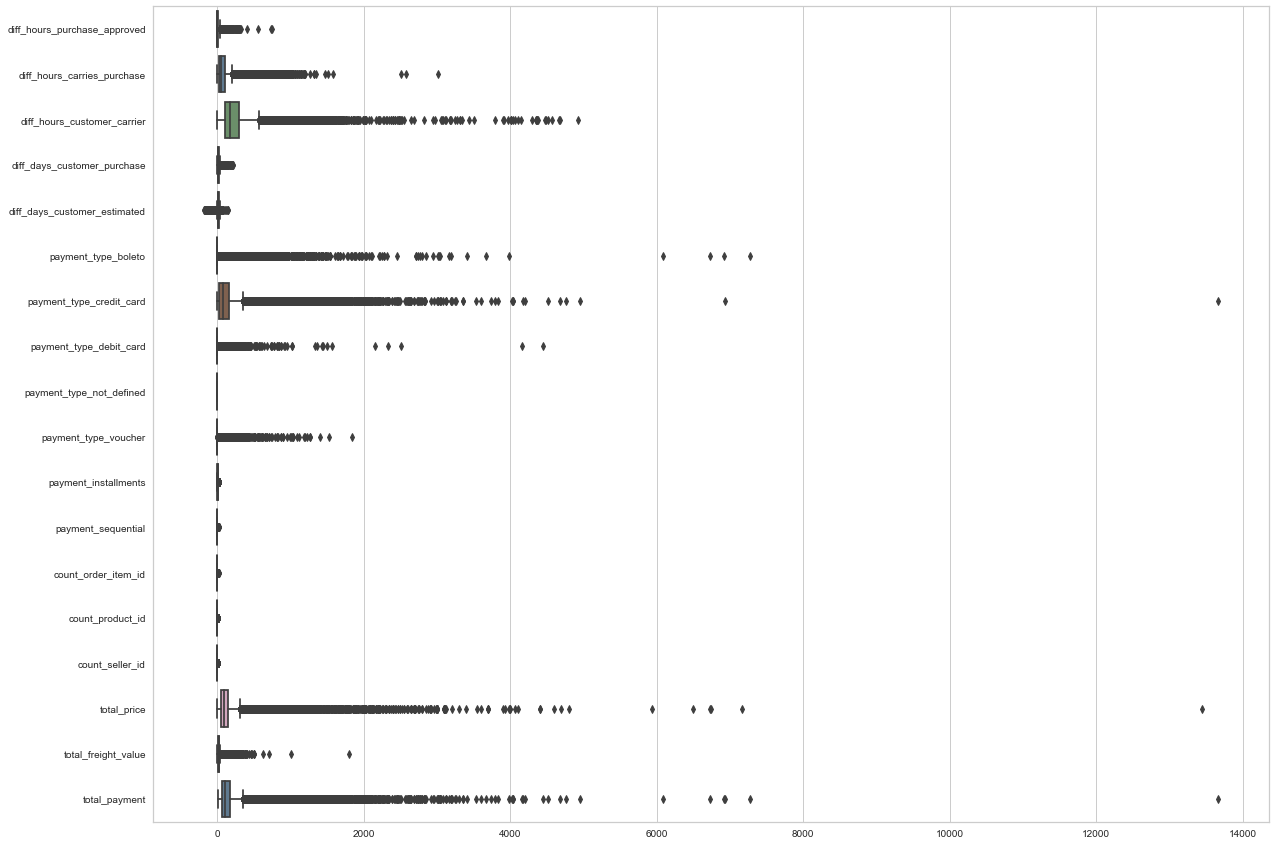

In [106]:
## Tamanho da figura
plt.figure(figsize = (20,15))

## Paleta de cores
sns_my_palete_01 = sns.color_palette('Set1', 
                                     n_colors = 8,
                                     desat = 0.5)

## Criação do objeto referente a plotagem
ax = sns.boxplot(data = df_data,
                 palette = sns_my_palete_01,
                 orient='h')

## Exibir gráfico
plt.show()

<a id ='542'></a>
<h5>5.4.2 Analisando variáveis numéricas</h5>

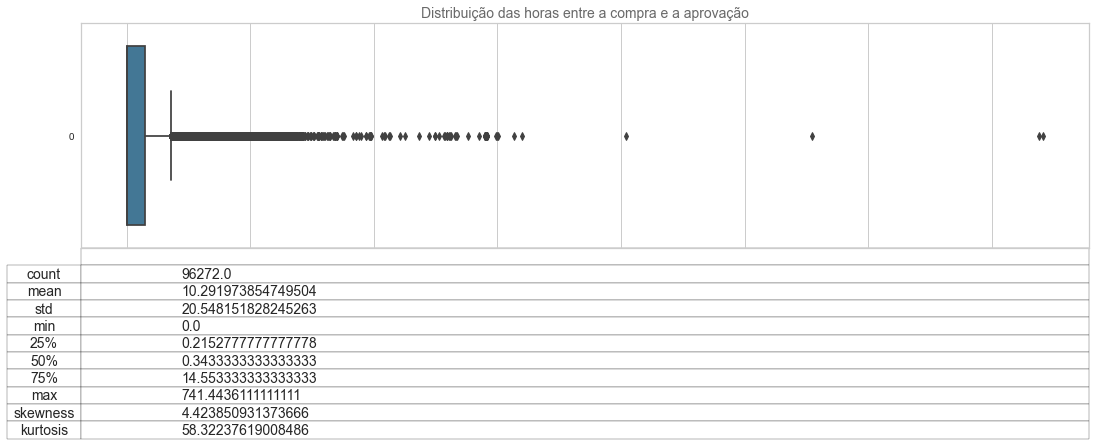

In [107]:
# Chamando a funcao para fazer a plotagem
col = 'diff_hours_purchase_approved'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição das horas entre a compra e a aprovação', palette='mako')

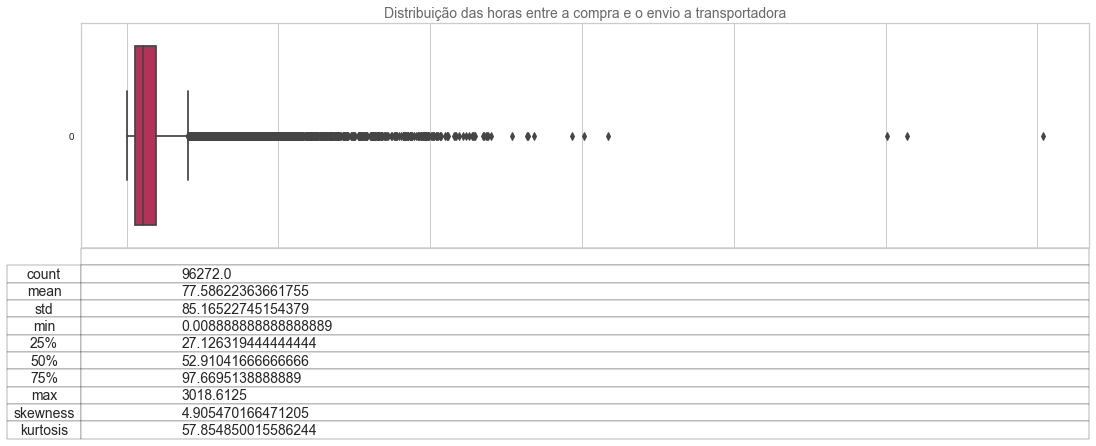

In [108]:
# Chamando a funcao para fazer a plotagem
col = 'diff_hours_carries_purchase'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição das horas entre a compra e o envio a transportadora', palette='rocket')

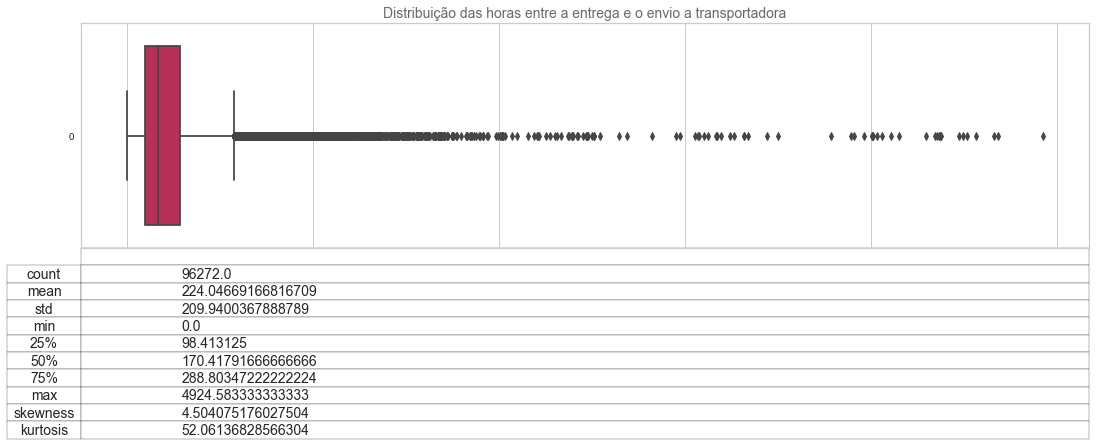

In [109]:
# Chamando a funcao para fazer a plotagem
col = 'diff_hours_customer_carrier'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição das horas entre a entrega e o envio a transportadora', palette='rocket')

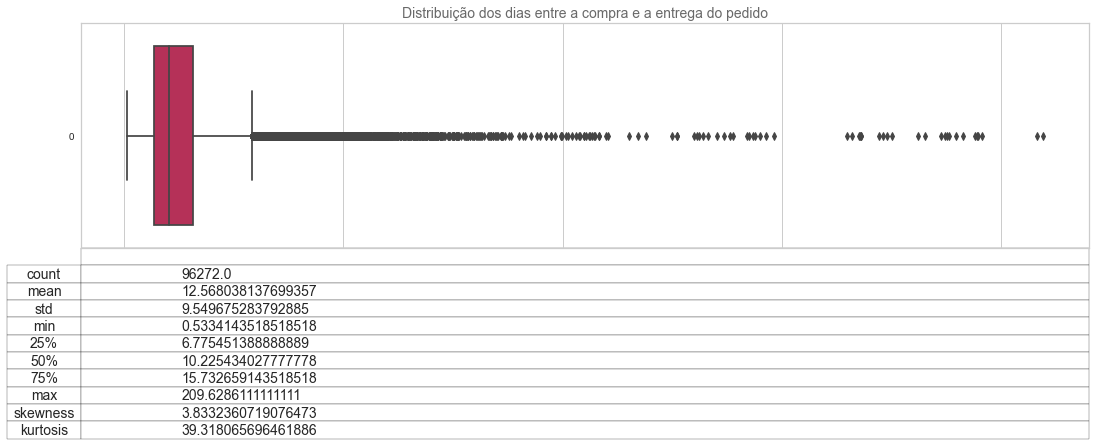

In [110]:
# Chamando a funcao para fazer a plotagem
col = 'diff_days_customer_purchase'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dias entre a compra e a entrega do pedido', palette='rocket')

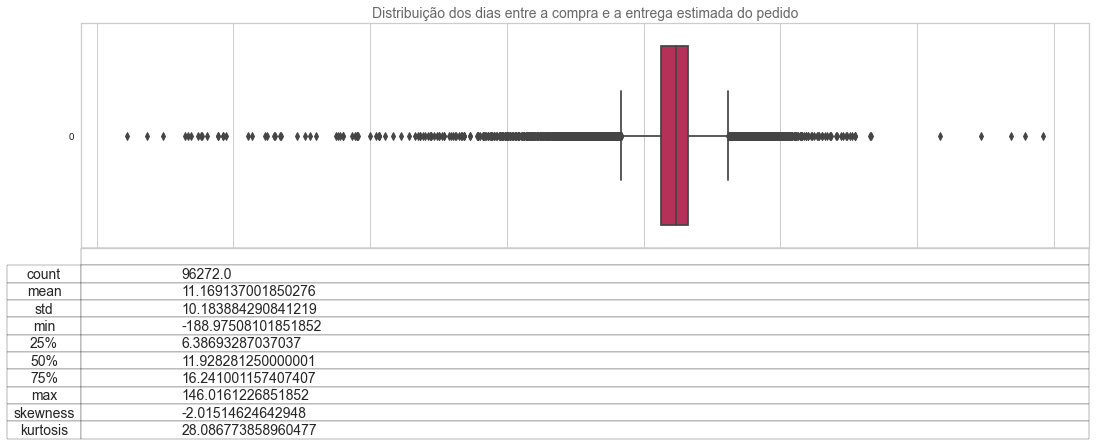

In [111]:
# Chamando a funcao para fazer a plotagem
col = 'diff_days_customer_estimated'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dias entre a compra e a entrega estimada do pedido', palette='rocket')

A diferença de dias e horas entre as muitas datas existentes no _dataset_ não obedece uma distribuição normal, além de apresentar muitos outliers. Contudo esses outliers fazem sentido para o negócio.

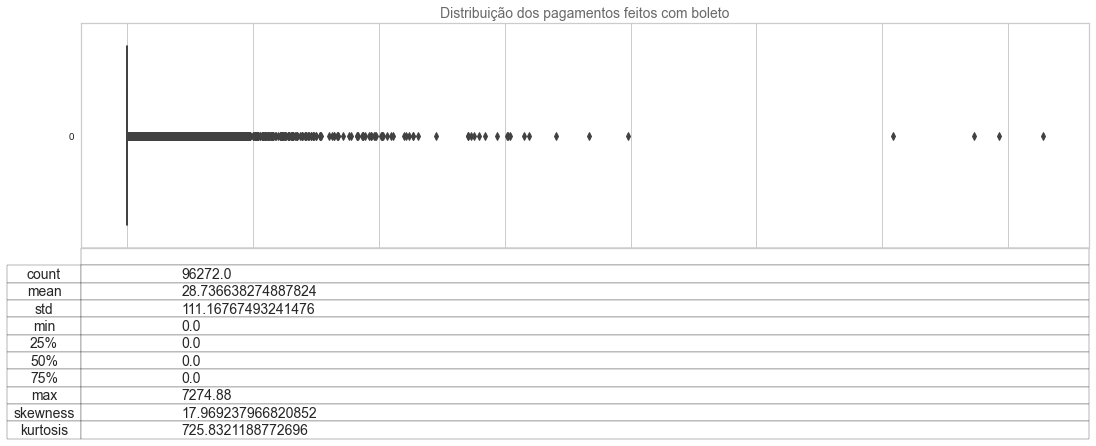

In [112]:
# Chamando a funcao para fazer a plotagem
col = 'payment_type_boleto'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos pagamentos feitos com boleto', palette='mako')

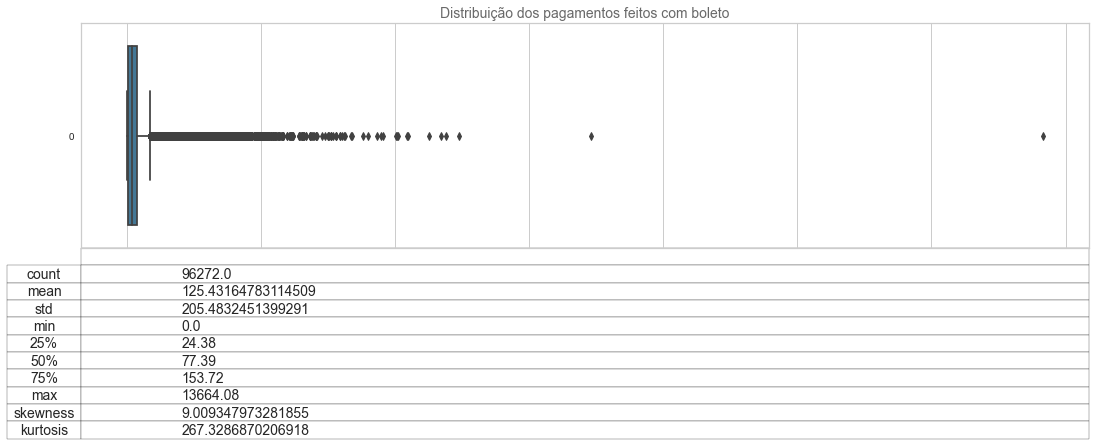

In [113]:
# Chamando a funcao para fazer a plotagem
col = 'payment_type_credit_card'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos pagamentos feitos com boleto', palette='mako')

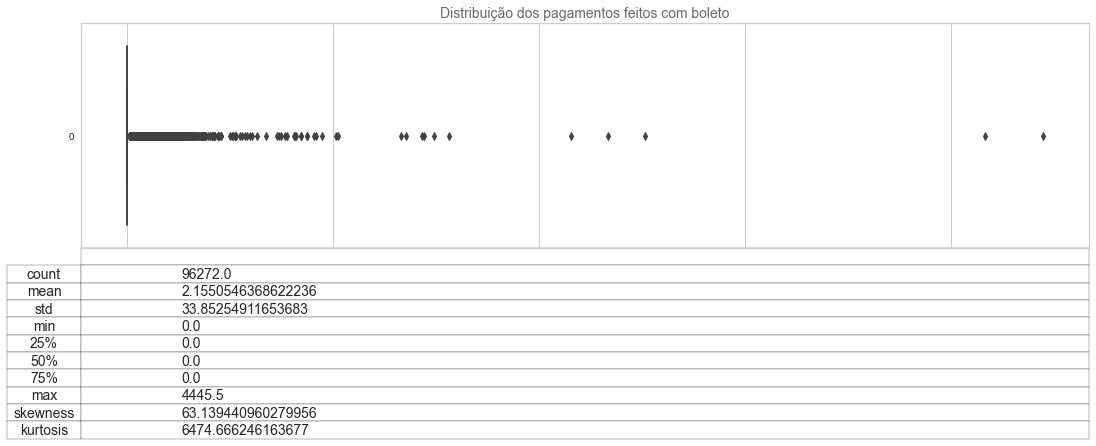

In [114]:
# Chamando a funcao para fazer a plotagem
col = 'payment_type_debit_card'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos pagamentos feitos com boleto', palette='mako')

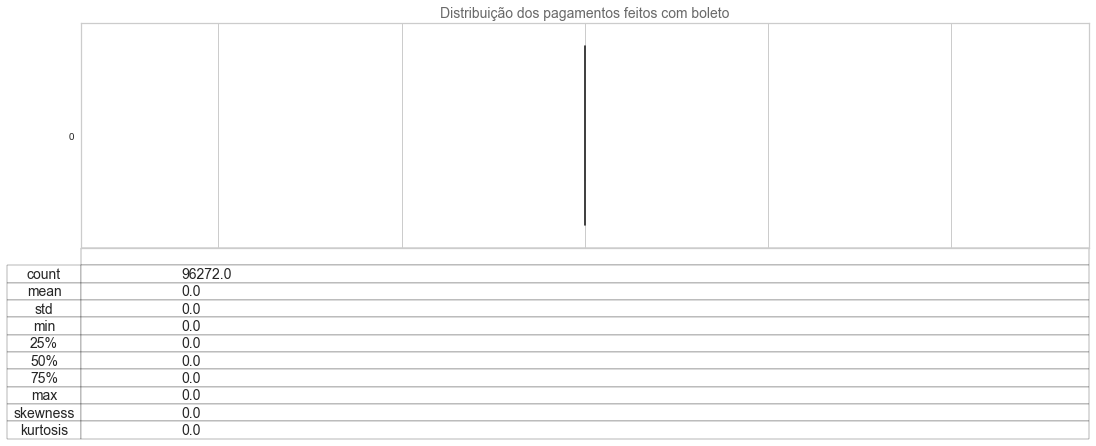

In [115]:
# Chamando a funcao para fazer a plotagem
col = 'payment_type_not_defined'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos pagamentos feitos com boleto', palette='mako')

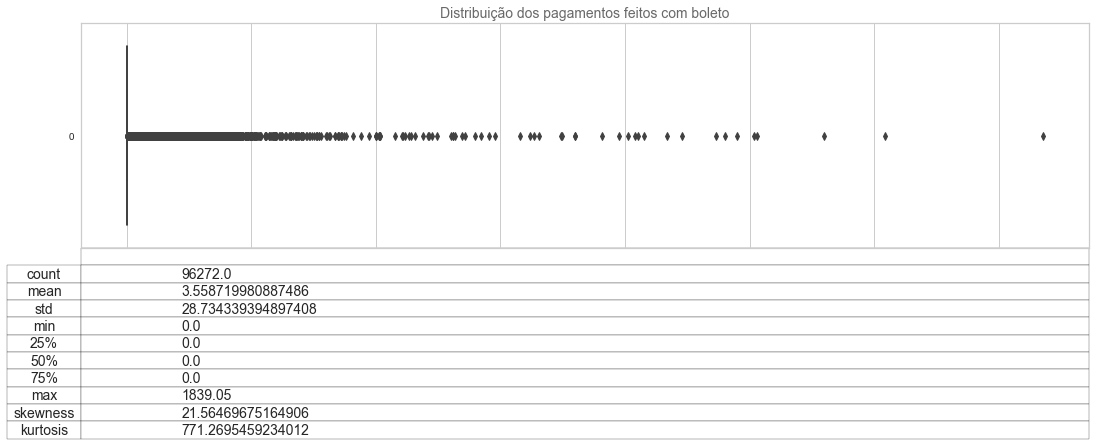

In [116]:
# Chamando a funcao para fazer a plotagem
col = 'payment_type_voucher'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos pagamentos feitos com boleto', palette='mako')

Também foram identificados outliers nos dados de pagamento, que mais uma vez fazem sentido. Há compra que são feitas em diversos metódos, e aquelas que são feitas em apenas um, isso explica muitos dos dados apresentados

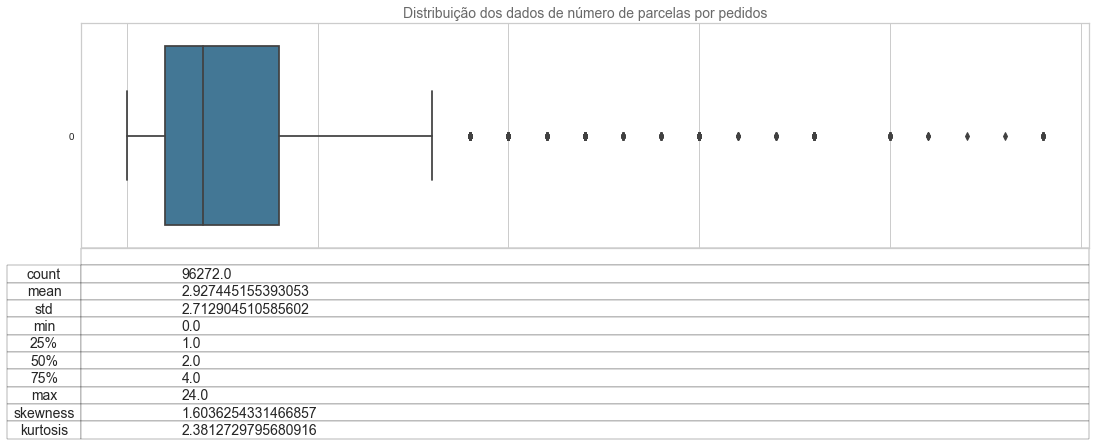

In [117]:
# Chamando a funcao para fazer a plotagem
col = 'payment_installments'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de número de parcelas por pedidos', palette='mako')

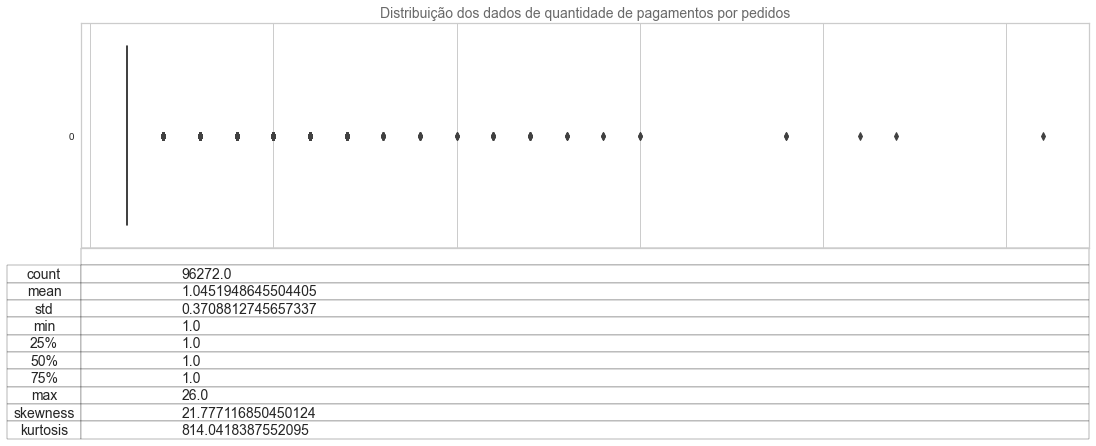

In [118]:
# Chamando a funcao para fazer a plotagem
col = 'payment_sequential'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de quantidade de pagamentos por pedidos', palette='mako')

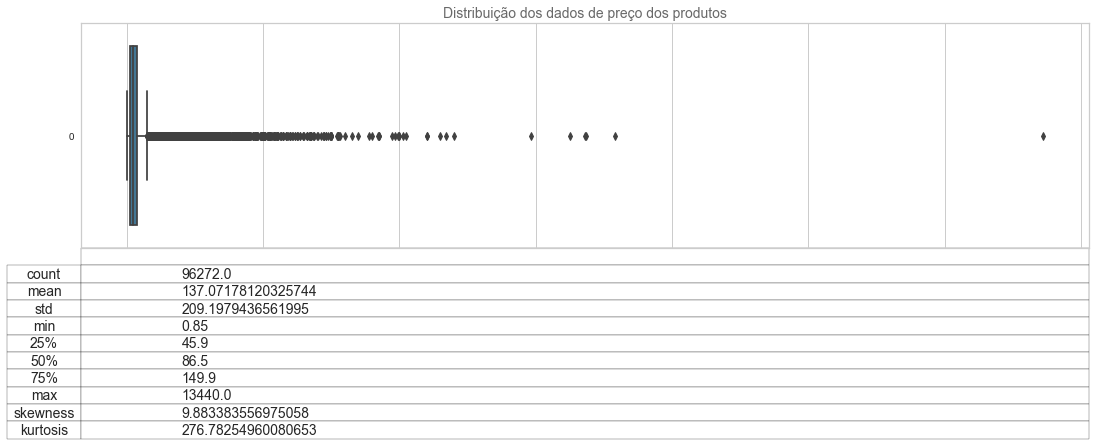

In [119]:
# Chamando a funcao para fazer a plotagem
col = 'total_price'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de preço dos produtos', palette='mako')

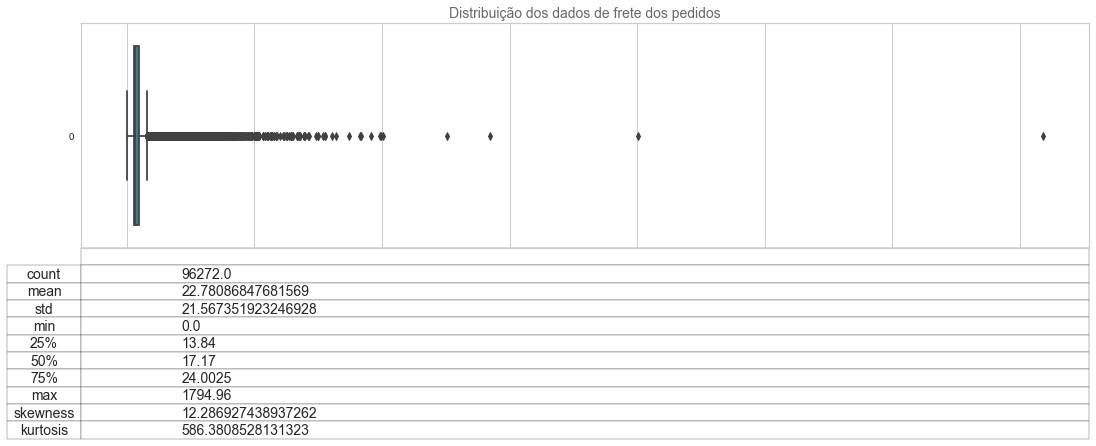

In [120]:
# Chamando a funcao para fazer a plotagem
col = 'total_freight_value'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de frete dos pedidos', palette='mako')

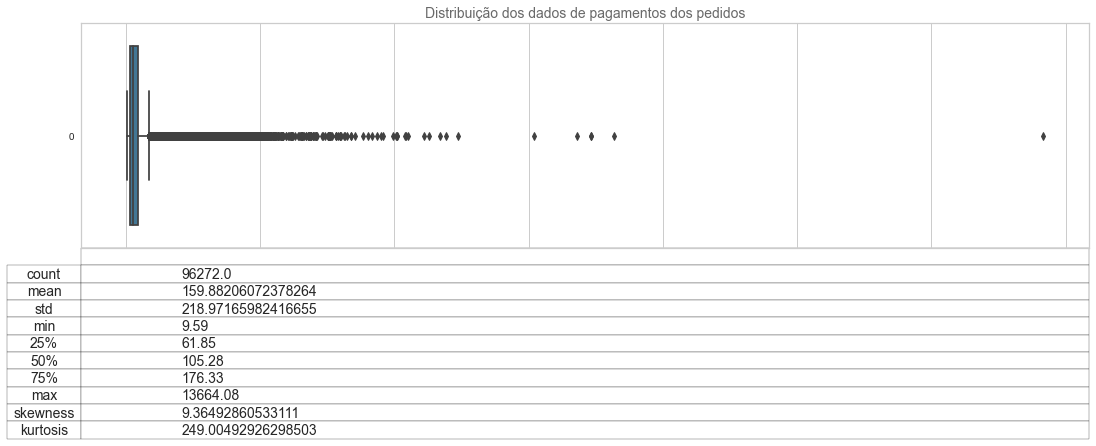

In [121]:
# Chamando a funcao para fazer a plotagem
col = 'total_payment'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de pagamentos dos pedidos', palette='mako')

Analisando os dados de pagamento, frete e preço dos produtos é possível identificar outliers contudo eles fazem sentido, dado que a loja vende produtos de inúmeros valores, desde canetas até geladeiras.

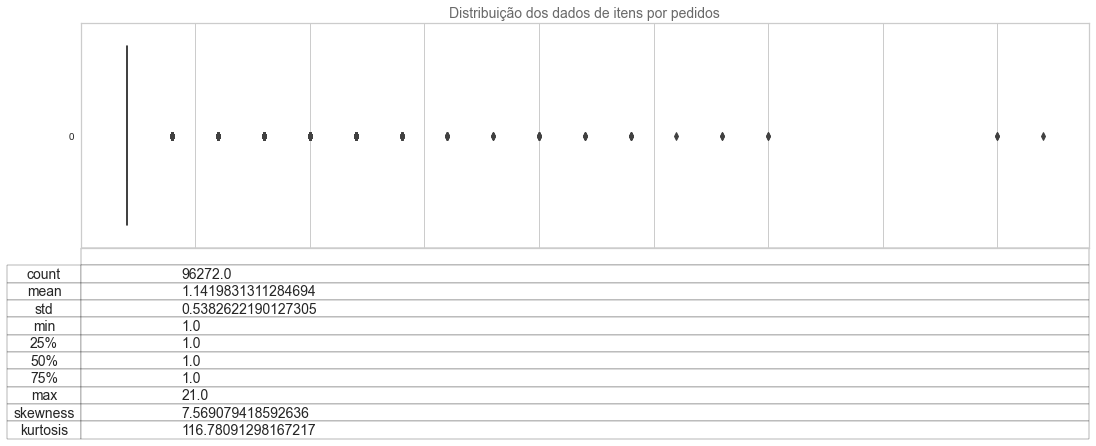

In [122]:
# Chamando a funcao para fazer a plotagem
col = 'count_order_item_id'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de itens por pedidos', palette='mako')

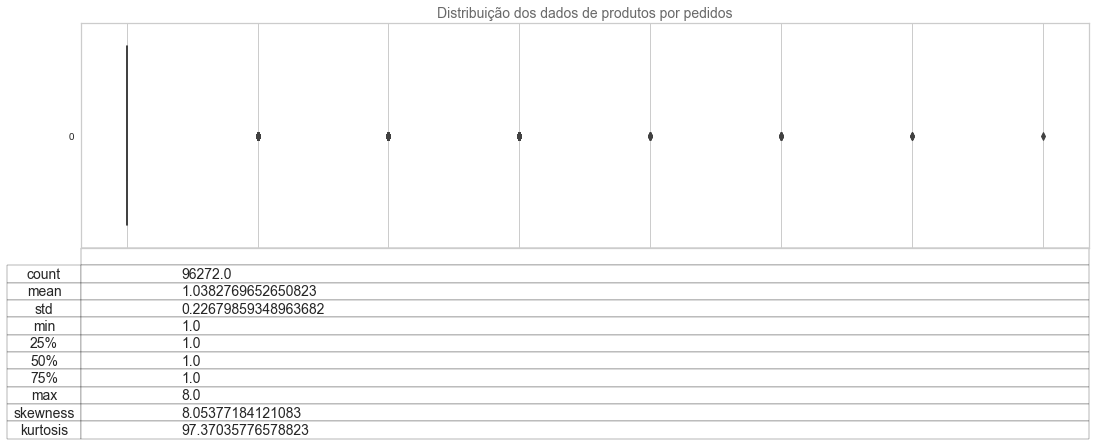

In [123]:
# Chamando a funcao para fazer a plotagem
col = 'count_product_id'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição dos dados de produtos por pedidos', palette='mako')

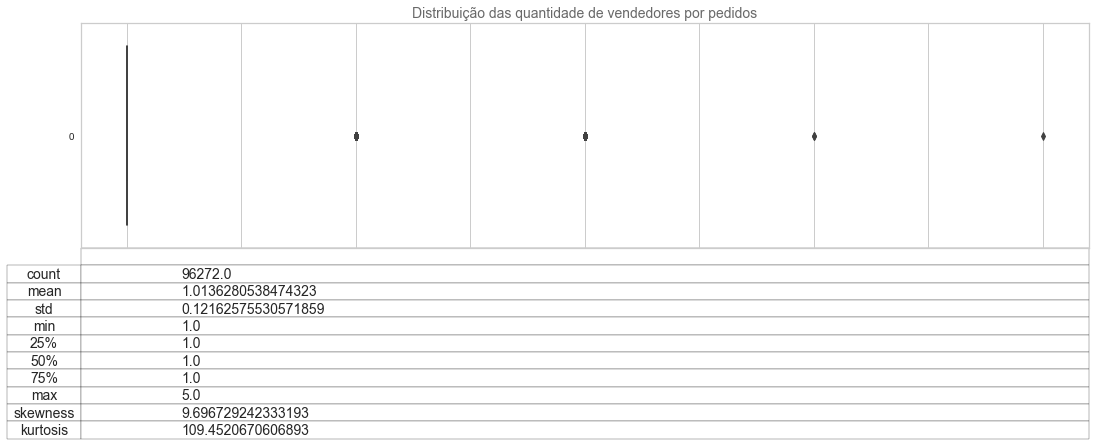

In [124]:
# Chamando a funcao para fazer a plotagem
col = 'count_seller_id'
fig, ax = plt.subplots(figsize=(20, 4))
boxplot(df_data, column=col, ax=ax, title='Distribuição das quantidade de vendedores por pedidos', palette='mako')

<a id ='543'></a>
<h5>5.4.3 Correlação dos dados</h5>

In [125]:
# Verificando a correlacao das variaveis
df_corr = df_data.drop(['payment_type_not_defined'], axis=1).corr()

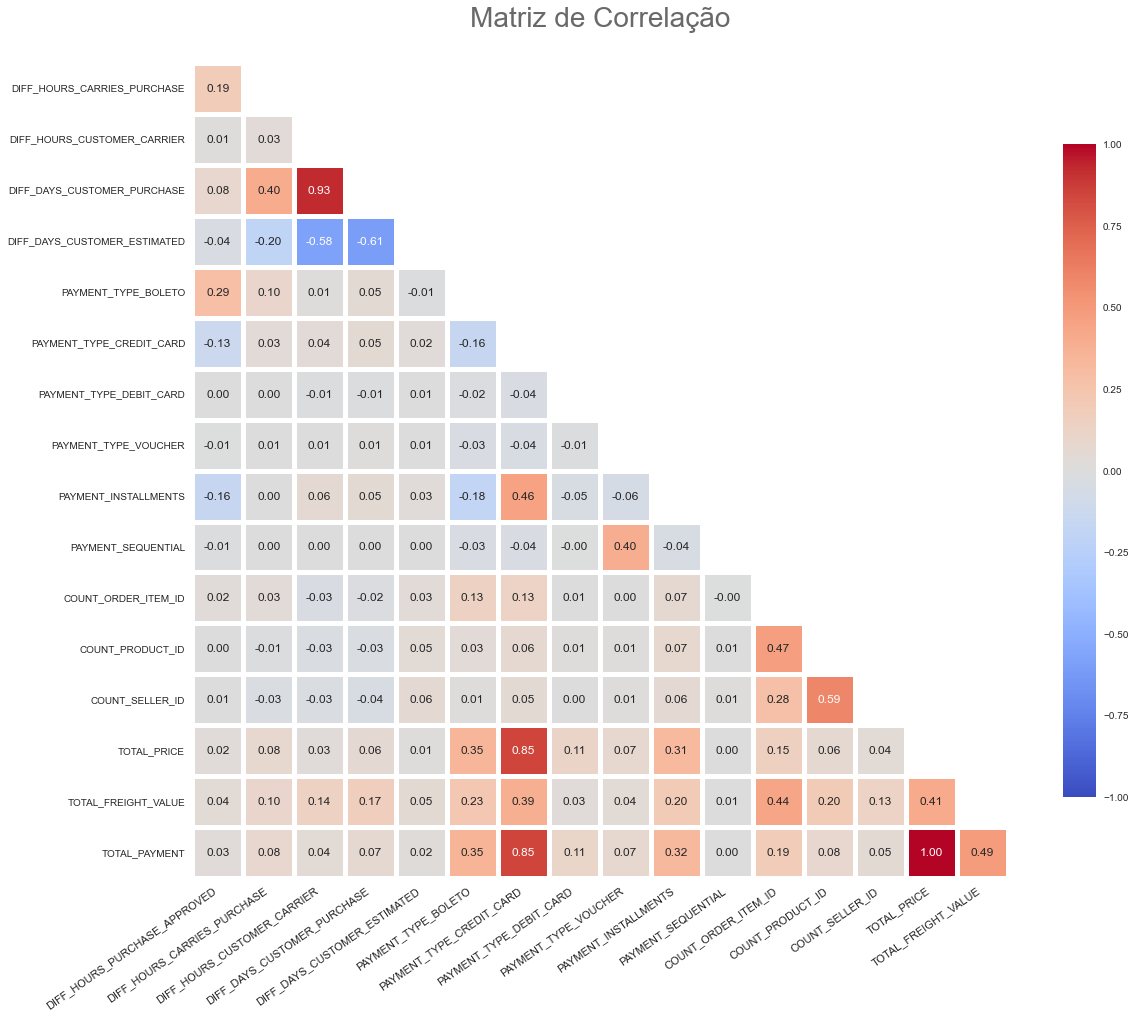

In [126]:
fig, ax = plt.subplots(figsize=(20, 15))

heatmap_plot(df_corr=df_corr, ax=ax, title="Matriz de Correlação", title_size=28)

<a id ='53'></a>
<h4>5.5. Analise geral dos dado (Captando alguns insights)</h4>

<a id ='551'></a>
<h5>5.5.1 Pedidos e Pagamentos</h5>

In [127]:
## Realizando o agrupamento por data
df_aux = df_data.groupby([df_data.order_purchase_timestamp.dt.to_period('M')]).agg({'order_id': 'nunique', 
                                                                                    'customer_unique_id': 'nunique',
                                                                                    'total_price': 'sum',
                                                                                    'total_freight_value': 'sum'}) \
                                                      .reset_index()

df_aux["ticket_medio"] = df_aux["total_price"] / df_aux["order_id"]
df_aux["frete_medio"] = df_aux["total_freight_value"] / df_aux["order_id"]

In [128]:
## Visualizando os primeiros registros
df_aux.head(3)

,order_purchase_timestamp,order_id,customer_unique_id,total_price,total_freight_value,ticket_medio,frete_medio
0,2016-10,266,263,40354.36,6181.95,151.708120,23.240414
1,2016-12,1,1,10.90,8.72,10.900000,8.720000
2,2017-01,747,716,111523.82,15636.97,149.295609,20.933025


In [129]:
print("Menor data pedido: ", df_data["order_purchase_timestamp"].min(), "\nMaior data pedido: ", df_data["order_purchase_timestamp"].max())

Menor data pedido:  2016-10-03 09:44:50 
Maior data pedido:  2018-08-29 15:00:37


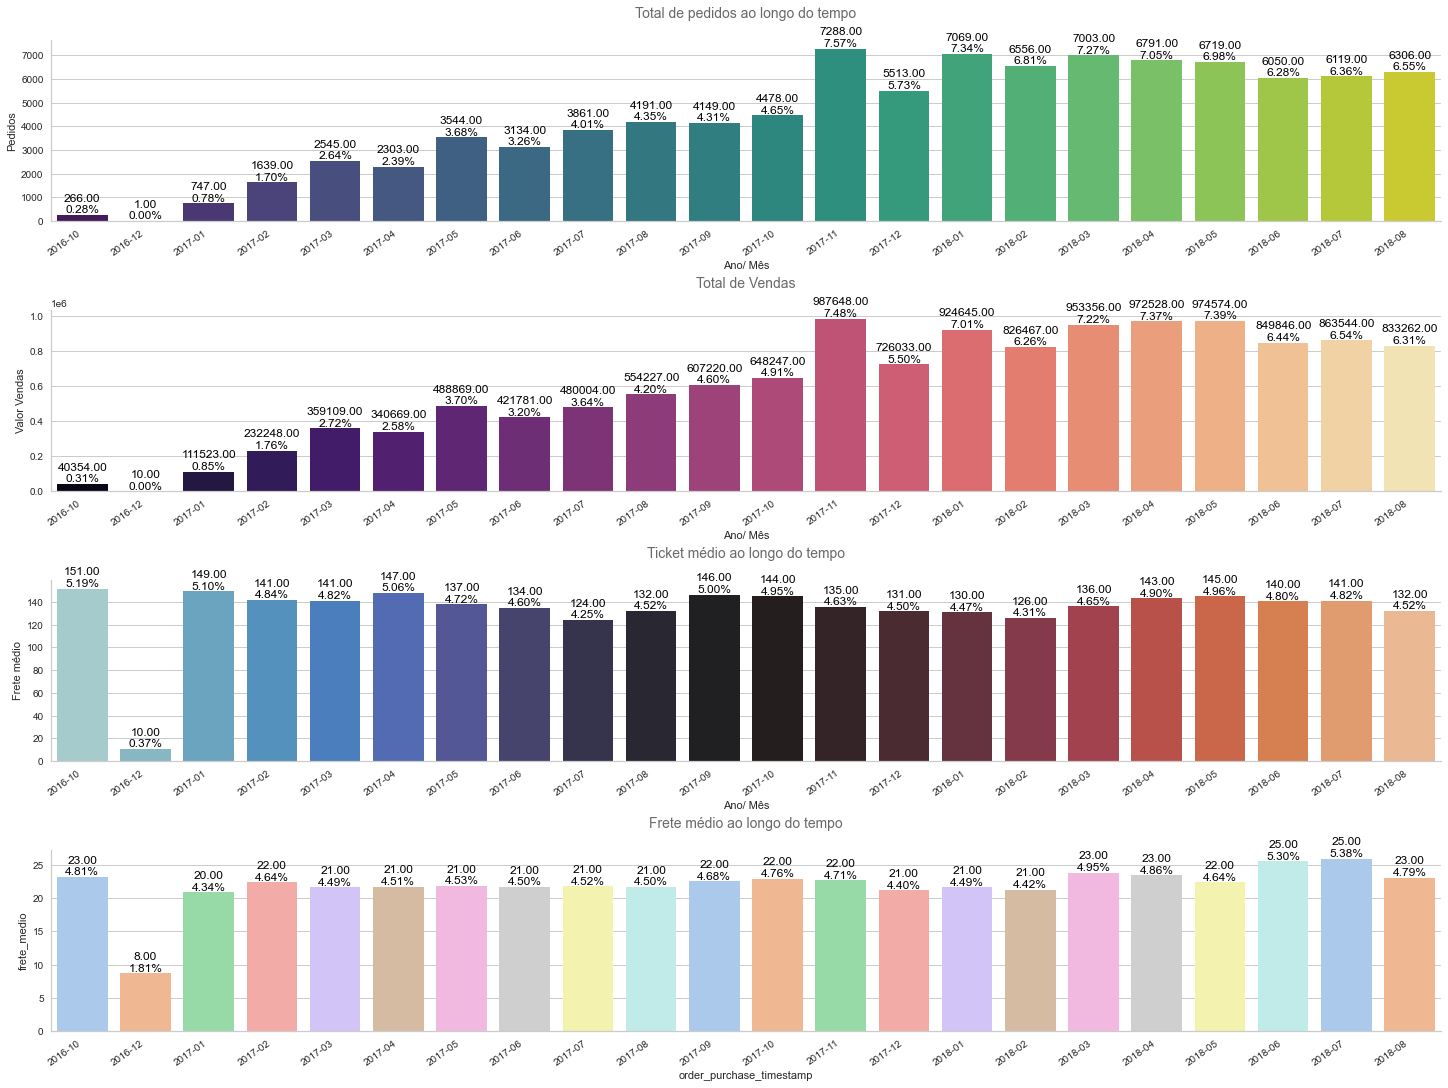

In [130]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[3, :])

## Gráfico 1
bar_plot(df_aux, 
               x='order_purchase_timestamp', 
               y="order_id",
               ax=ax1,
               palette='viridis',
               title='Total de pedidos ao longo do tempo')
ax1.set_ylabel('Pedidos')
ax1.set_xlabel('Ano/ Mês')

## Gráfico 2
## Total de Clientes por Estado
bar_plot(df_aux, 
               x='order_purchase_timestamp', 
               y="total_price",
               ax=ax2,
               palette='magma',
               title='Total de Vendas')
ax2.set_ylabel('Valor Vendas')
ax2.set_xlabel('Ano/ Mês')

## Gráfico 3
bar_plot(df_aux, 
               x='order_purchase_timestamp', 
               y="ticket_medio",
               ax=ax3,
               palette='icefire',
               title='Ticket médio ao longo do tempo')
ax3.set_ylabel('Ticket médio')
ax3.set_xlabel('Ano/ Mês')

## Gráfico 4
bar_plot(df_aux, 
               x='order_purchase_timestamp', 
               y="frete_medio",
               ax=ax4,
               palette='pastel',
               title='Frete médio ao longo do tempo')
ax3.set_ylabel('Frete médio')
ax3.set_xlabel('Ano/ Mês')


plt.show()

Observando os dados de pedidos que faz sentido aplicar um filtro de data entre **01/01/2017** e **31/08/2018**. Assim é possível fazer um comparativo da evolução das vendas nos meses de cada ano.

In [131]:
## Aplicando filtro
df_data_filter = df_data.loc[(df_data['order_purchase_timestamp'] >= '2017-01-01') & (df_data['order_purchase_timestamp'] < '2018-09-01')]

In [132]:
## Extraindo Ano
df_data_filter['order_purchase_year'] = df_data_filter['order_purchase_timestamp'].dt.year
## Extraindo mês
df_data_filter['order_purchase_month'] = df_data_filter['order_purchase_timestamp'].dt.month
## Extraindo nome do mês
df_data_filter['order_purchase_month_name'] = pd.to_datetime(df_data_filter['order_purchase_timestamp']).dt.strftime('%B')
## Coluna Ano mes
df_data_filter['order_purchase_year_month'] = df_data_filter['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))

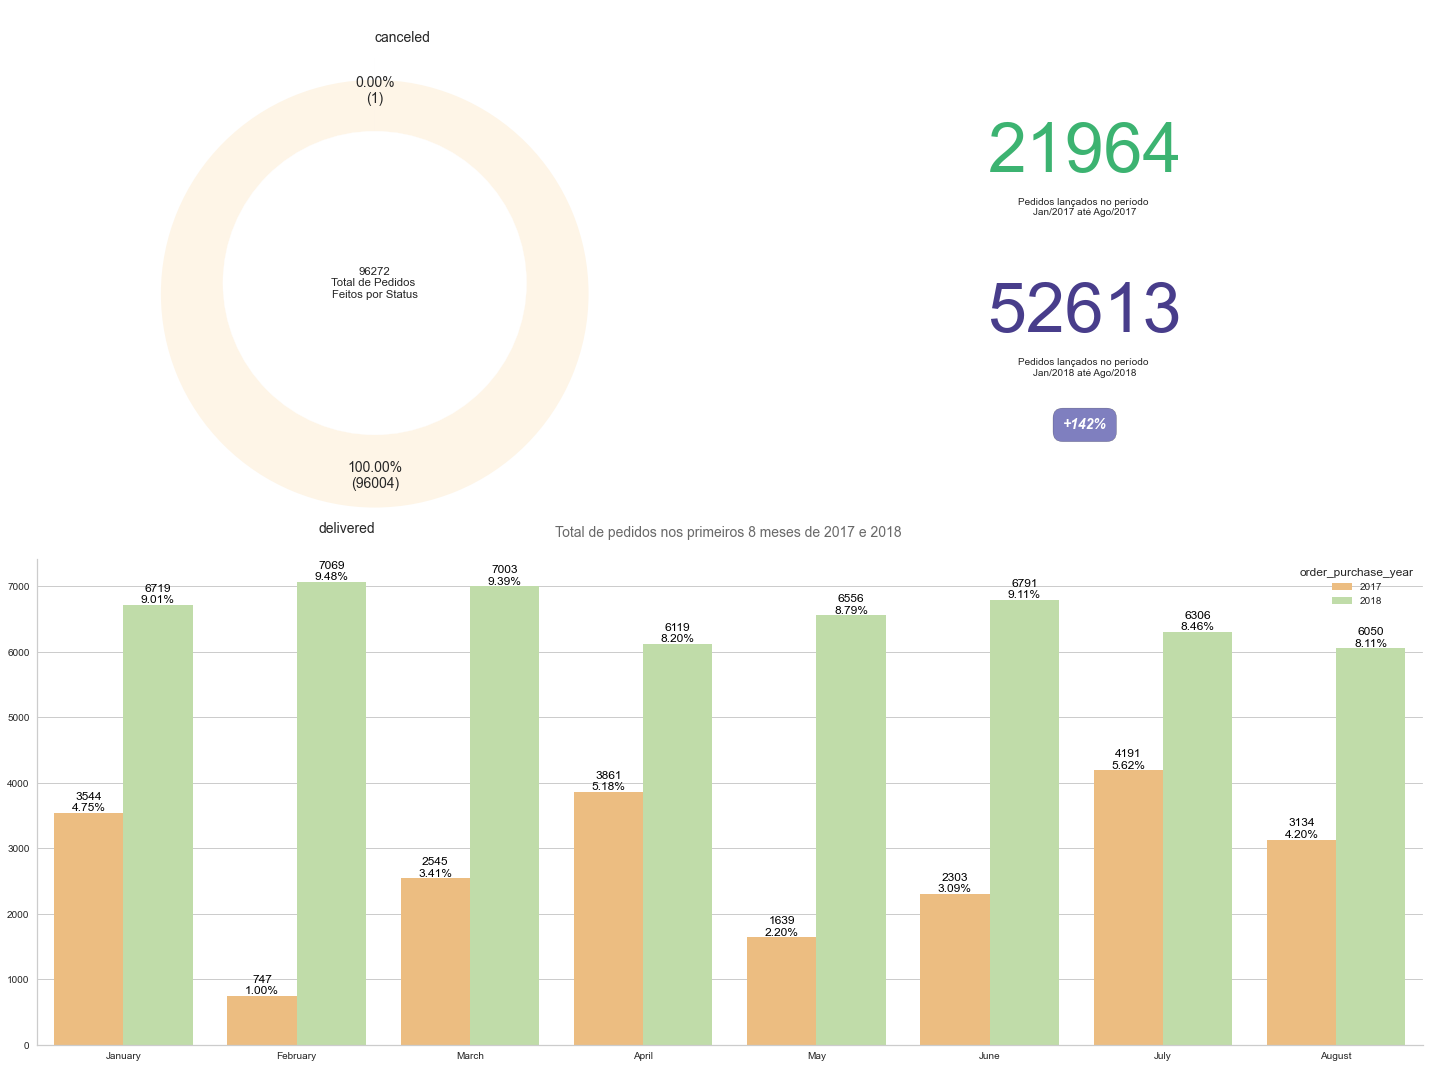

In [133]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

## Gráfico 1
colors = ['#FEF5E7','#F4ECF7' , '#EBEDEF']
label_names = df_data_filter['order_status'].value_counts().index
pie_plot(df_data_filter, 
         col='order_status', 
         ax=ax1, 
         label_names=label_names, 
         colors=colors,
         circle_radius=0.71,
         title='', 
         text=f'{len(df_data)}\nTotal de Pedidos \nFeitos por Status')

## Gráfico 2
year_orders = df_data_filter.loc[(df_data_filter['order_purchase_month'] <= 8)]['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax2.text(0.50, 0.73, f'{year_orders[2017]}', fontsize=70, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.64, 'Pedidos lançados no período \nJan/2017 até Ago/2017', fontsize=10, ha='center')
ax2.text(0.50, 0.40, f'{year_orders[2018]}', fontsize=70, color='darkslateblue', ha='center')
ax2.text(0.50, 0.31, 'Pedidos lançados no período \nJan/2018 até Ago/2018', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

## Gráfico 3
df_aux2 = df_data_filter.loc[(df_data_filter['order_purchase_month'] <= 8)]
month_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
bar_count_plot(df_aux2, 
               x='order_purchase_month_name', 
               ax=ax3,
               hue='order_purchase_year',
               palette='Spectral',
               title='Total de pedidos nos primeiros 8 meses de 2017 e 2018 ')
ax3.set_xticklabels(month_label)
ax3.set_ylabel('')
ax3.set_xlabel('')
plt.show()


A seguir veremos os dados de pedido, faturamento e frete obtidos ao longo do período

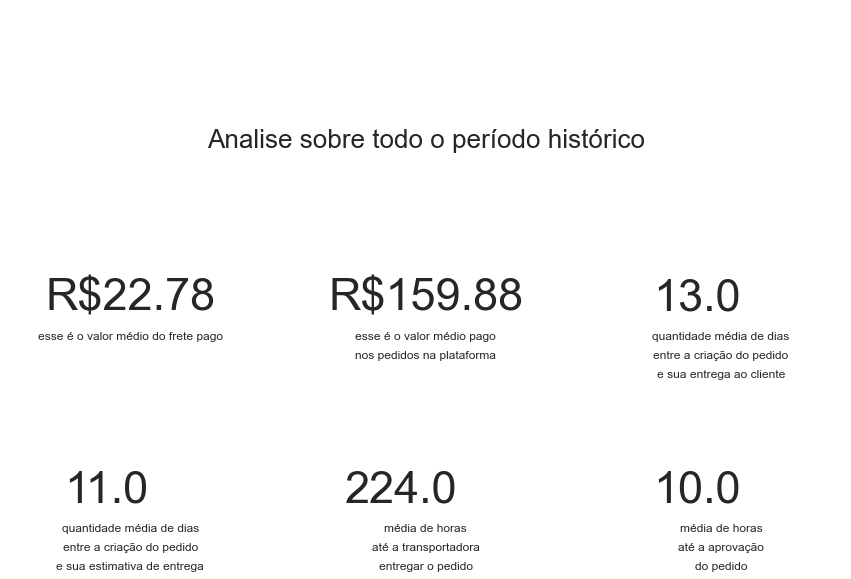

In [134]:
## Objetos referentes as figuras
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Titulo
axs[0, 1].text(0.50, 0.12, 'Analise sobre todo o período histórico', fontsize=26, ha='center')
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[0, 2].axis('off')

## Cards
# Frete
axs[1, 0].text(0.50, 0.30, f'R${round(df_data["total_freight_value"].mean(), 2)}', fontsize=45, ha='center')
axs[1, 0].text(0.50, 0.12, 'esse é o valor médio do frete pago', fontsize=12, ha='center')
axs[1, 0].axis('off')

# Compra
axs[1, 1].text(0.50, 0.30, f'R${round(df_data["total_payment"].mean(), 2)}', fontsize=45, ha='center')
axs[1, 1].text(0.50, 0.12, 'esse é o valor médio pago', fontsize=12, ha='center')
axs[1, 1].text(0.50, 0.00, 'nos pedidos na plataforma', fontsize=12, ha='center')
axs[1, 1].axis('off')

# Tempo espera
axs[1, 2].text(0.40, 0.30, f'{round(df_data["diff_days_customer_purchase"].mean(), 0)}', fontsize=45, ha='center')
axs[1, 2].text(0.50, 0.12, 'quantidade média de dias', fontsize=12, ha='center')
axs[1, 2].text(0.50, 0.00, 'entre a criação do pedido', fontsize=12, ha='center')
axs[1, 2].text(0.50, -0.12, 'e sua entrega ao cliente', fontsize=12, ha='center')
axs[1, 2].axis('off')

# Tempo espera estimado
axs[2, 0].text(0.40, 0.30, f'{round(df_data["diff_days_customer_estimated"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 0].text(0.50, 0.12, 'quantidade média de dias', fontsize=12, ha='center')
axs[2, 0].text(0.50, 0.00, 'entre a criação do pedido', fontsize=12, ha='center')
axs[2, 0].text(0.50, -0.12, 'e sua estimativa de entrega', fontsize=12, ha='center')
axs[2, 0].axis('off')

# Tempo transportadora
axs[2, 1].text(0.40, 0.30, f'{round(df_data["diff_hours_customer_carrier"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 1].text(0.50, 0.12, 'média de horas', fontsize=12, ha='center')
axs[2, 1].text(0.50, 0.00, 'até a transportadora', fontsize=12, ha='center')
axs[2, 1].text(0.50, -0.12, 'entregar o pedido', fontsize=12, ha='center')
axs[2, 1].axis('off')

# Tempo aprovação
axs[2, 2].text(0.40, 0.30, f'{round(df_data["diff_hours_purchase_approved"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 2].text(0.50, 0.12, 'média de horas', fontsize=12, ha='center')
axs[2, 2].text(0.50, 0.00, 'até a aprovação', fontsize=12, ha='center')
axs[2, 2].text(0.50, -0.12, 'do pedido', fontsize=12, ha='center')
axs[2, 2].axis('off')

plt.show()

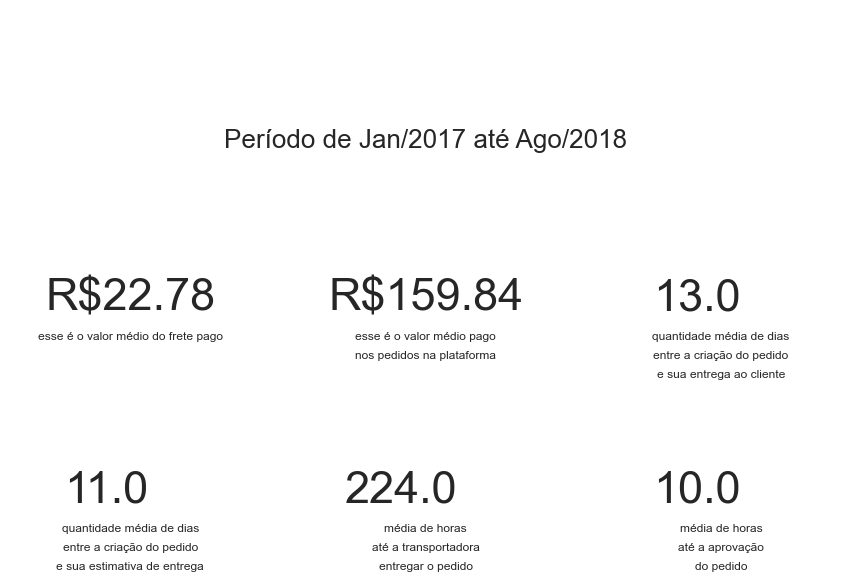

In [135]:
## Objetos referentes as figuras
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Titulo
axs[0, 1].text(0.50, 0.12, 'Período de Jan/2017 até Ago/2018', fontsize=26, ha='center')
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[0, 2].axis('off')

## Cards
# Frete
axs[1, 0].text(0.50, 0.30, f'R${round(df_data_filter["total_freight_value"].mean(), 2)}', fontsize=45, ha='center')
axs[1, 0].text(0.50, 0.12, 'esse é o valor médio do frete pago', fontsize=12, ha='center')
axs[1, 0].axis('off')

# Compra
axs[1, 1].text(0.50, 0.30, f'R${round(df_data_filter["total_payment"].mean(), 2)}', fontsize=45, ha='center')
axs[1, 1].text(0.50, 0.12, 'esse é o valor médio pago', fontsize=12, ha='center')
axs[1, 1].text(0.50, 0.00, 'nos pedidos na plataforma', fontsize=12, ha='center')
axs[1, 1].axis('off')

# Tempo espera
axs[1, 2].text(0.40, 0.30, f'{round(df_data_filter["diff_days_customer_purchase"].mean(), 0)}', fontsize=45, ha='center')
axs[1, 2].text(0.50, 0.12, 'quantidade média de dias', fontsize=12, ha='center')
axs[1, 2].text(0.50, 0.00, 'entre a criação do pedido', fontsize=12, ha='center')
axs[1, 2].text(0.50, -0.12, 'e sua entrega ao cliente', fontsize=12, ha='center')
axs[1, 2].axis('off')

# Tempo espera estimado
axs[2, 0].text(0.40, 0.30, f'{round(df_data_filter["diff_days_customer_estimated"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 0].text(0.50, 0.12, 'quantidade média de dias', fontsize=12, ha='center')
axs[2, 0].text(0.50, 0.00, 'entre a criação do pedido', fontsize=12, ha='center')
axs[2, 0].text(0.50, -0.12, 'e sua estimativa de entrega', fontsize=12, ha='center')
axs[2, 0].axis('off')

# Tempo transportadora
axs[2, 1].text(0.40, 0.30, f'{round(df_data_filter["diff_hours_customer_carrier"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 1].text(0.50, 0.12, 'média de horas', fontsize=12, ha='center')
axs[2, 1].text(0.50, 0.00, 'até a transportadora', fontsize=12, ha='center')
axs[2, 1].text(0.50, -0.12, 'entregar o pedido', fontsize=12, ha='center')
axs[2, 1].axis('off')

# Tempo aprovação
axs[2, 2].text(0.40, 0.30, f'{round(df_data_filter["diff_hours_purchase_approved"].mean(), 0)}', fontsize=45, ha='center')
axs[2, 2].text(0.50, 0.12, 'média de horas', fontsize=12, ha='center')
axs[2, 2].text(0.50, 0.00, 'até a aprovação', fontsize=12, ha='center')
axs[2, 2].text(0.50, -0.12, 'do pedido', fontsize=12, ha='center')
axs[2, 2].axis('off')

plt.show()

In [136]:
## Criando dataframe com os dadoa agrupados
df_payments_grouped = df_order_payments.groupby(['payment_type']).agg({'order_id': 'nunique',                                                                  
                                                                       'payment_value': 'sum'}) \
                                                                  .reset_index()
## Criando coluna referente valor medio gasto por pedido
df_payments_grouped["media_pedido"] = df_payments_grouped["payment_value"] / df_payments_grouped["order_id"]

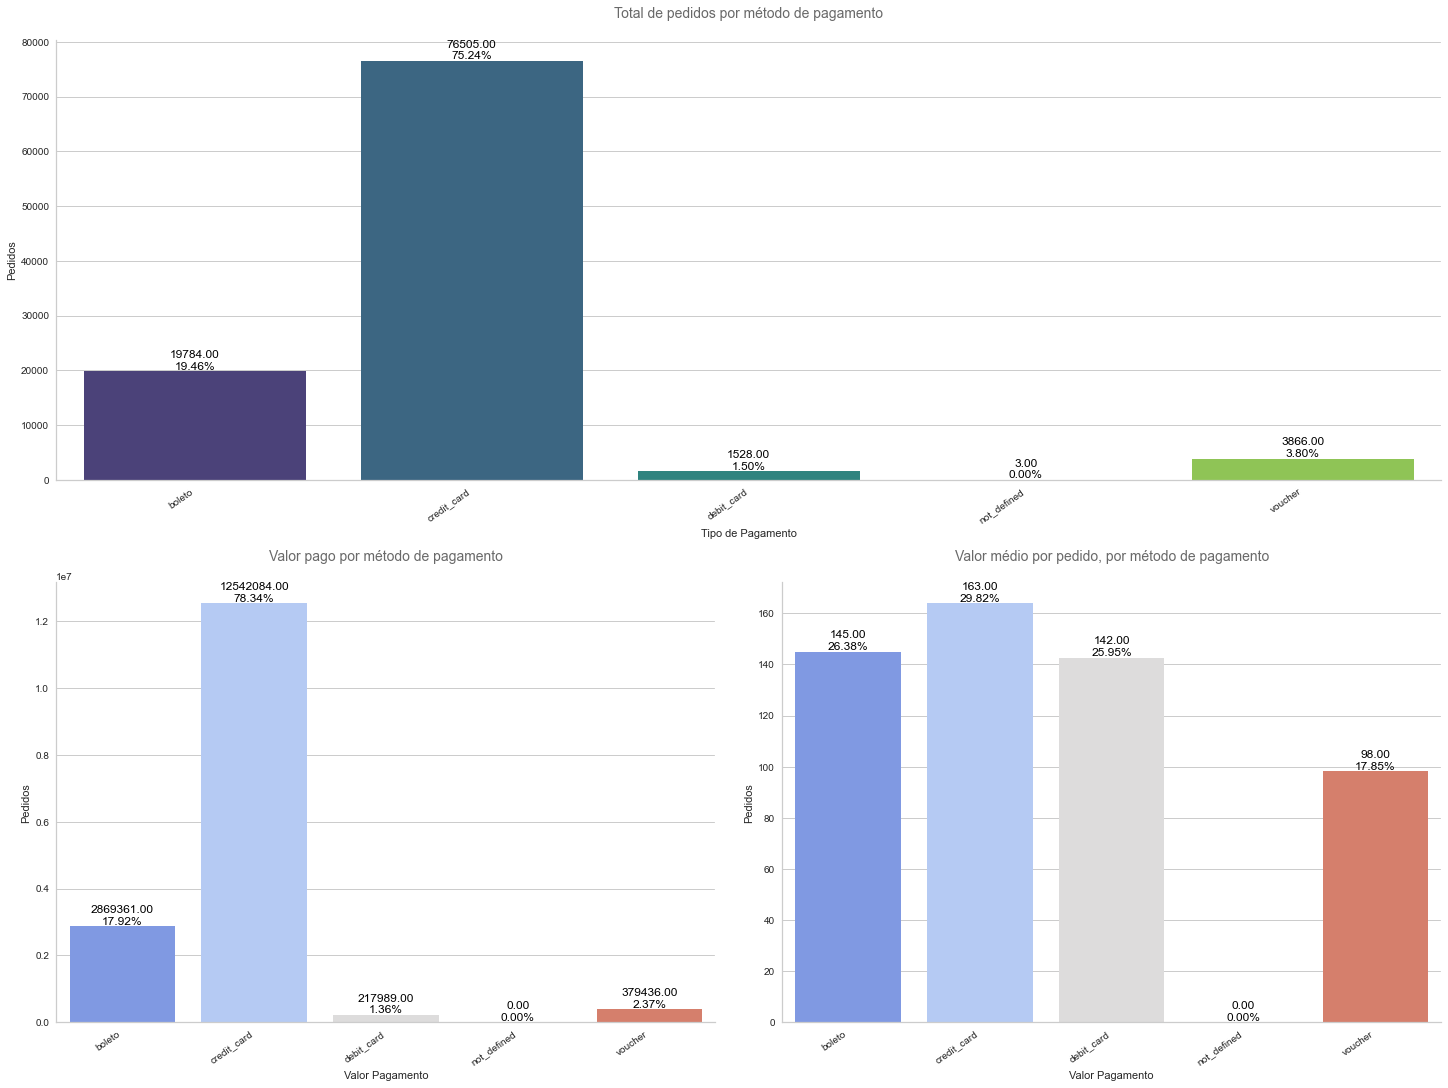

In [137]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

## Gráfico 1
bar_plot(df_payments_grouped, 
               x='payment_type', 
               y="order_id",
               ax=ax1,
               palette='viridis',
               title='Total de pedidos por método de pagamento')
ax1.set_ylabel('Pedidos')
ax1.set_xlabel('Tipo de Pagamento')

## Gráfico 2
bar_plot(df_payments_grouped, 
               x='payment_type', 
               y="payment_value",
               ax=ax2,
               palette='coolwarm',
               title='Valor pago por método de pagamento')
ax2.set_ylabel('Pedidos')
ax2.set_xlabel('Valor Pagamento')

## Gráfico 3
bar_plot(df_payments_grouped, 
               x='payment_type', 
               y="media_pedido",
               ax=ax3,
               palette='coolwarm',
               title='Valor médio por pedido, por método de pagamento')
ax3.set_ylabel('Pedidos')
ax3.set_xlabel('Valor Pagamento')

plt.show()

<a id ='552'></a>
<h5>5.5.2 Clientes</h5>

In [138]:
## Criando dataframe com os dadoa agrupados
df_customer_grouped = df_data.groupby(['customer_state']).agg({'order_id': 'nunique',                                                                  
                                                               'customer_unique_id': 'nunique',
                                                               'total_price': 'sum',
                                                               'total_freight_value': 'sum'}) \
                                                               .reset_index()
## Criando coluna referente valor medio gasto por pedido
df_customer_grouped["media_pedido"] = df_customer_grouped["total_price"] / df_customer_grouped["order_id"]
df_customer_grouped["media_frete"] = df_customer_grouped["total_freight_value"] / df_customer_grouped["order_id"]

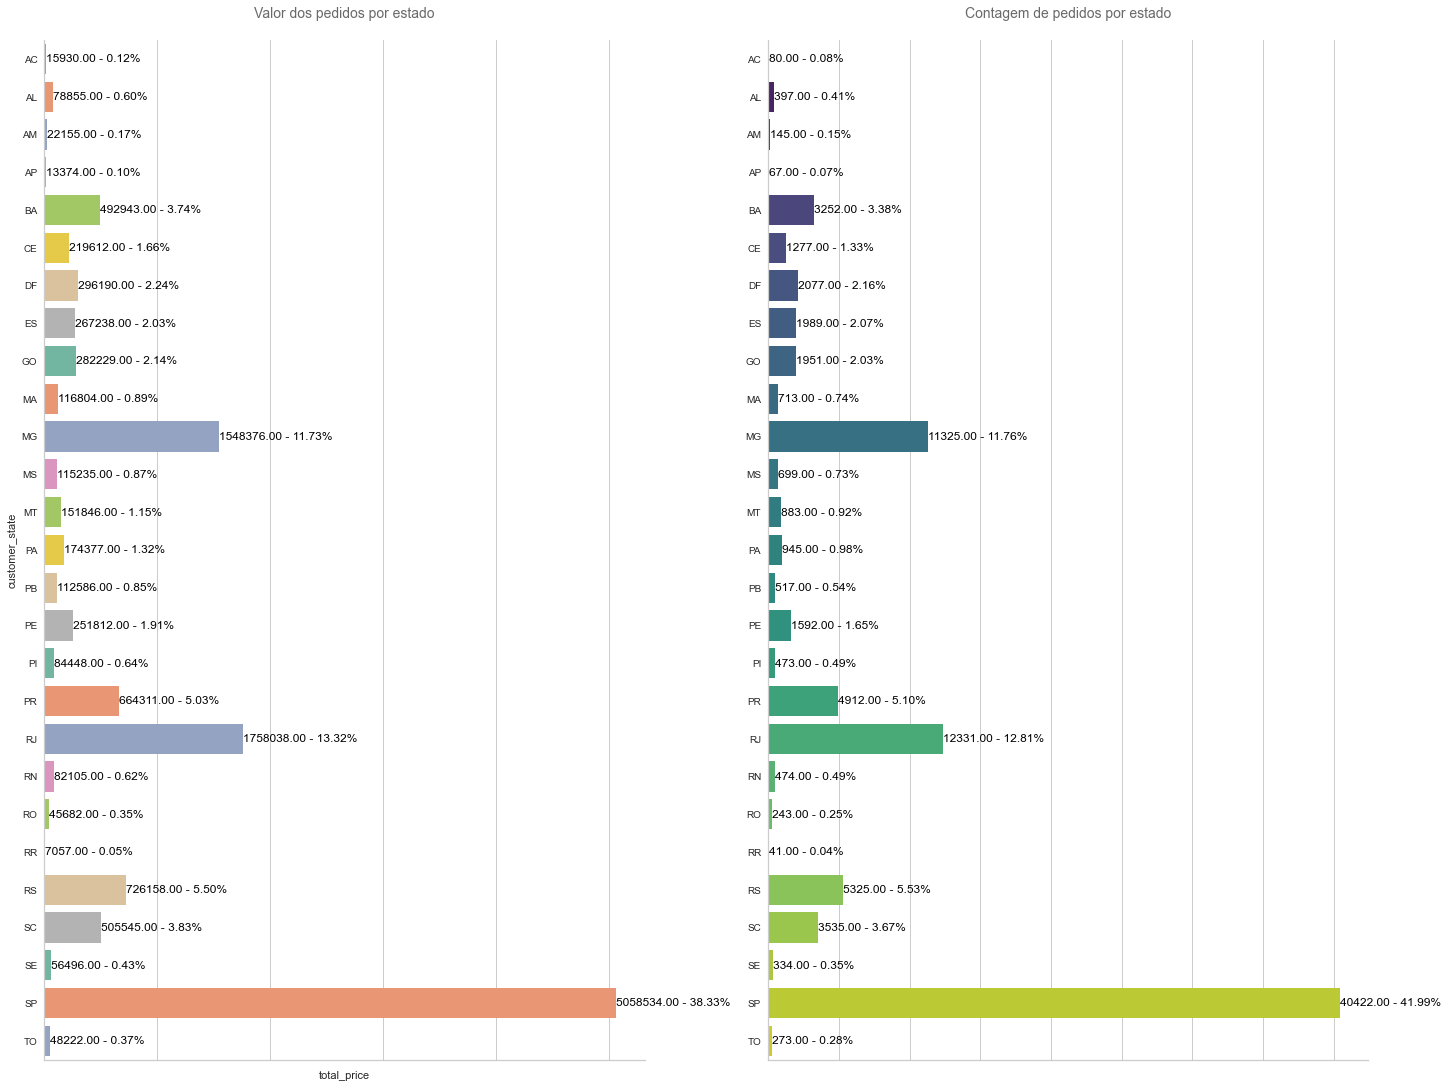

In [139]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

bar_plot(df_customer_grouped, 
         y='customer_state', 
         x='total_price',
         ax=ax1, 
         orient_horizontal = False,
         palette='Set2', 
         title='Valor dos pedidos por estado')
ax3.set_ylabel('')
ax3.set_xlabel('')

## Gráfico 3
bar_plot(df_customer_grouped, 
         y='customer_state', 
         x='order_id',
         ax=ax2, 
         orient_horizontal = False,
         palette='viridis', 
         title='Contagem de pedidos por estado')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.show()

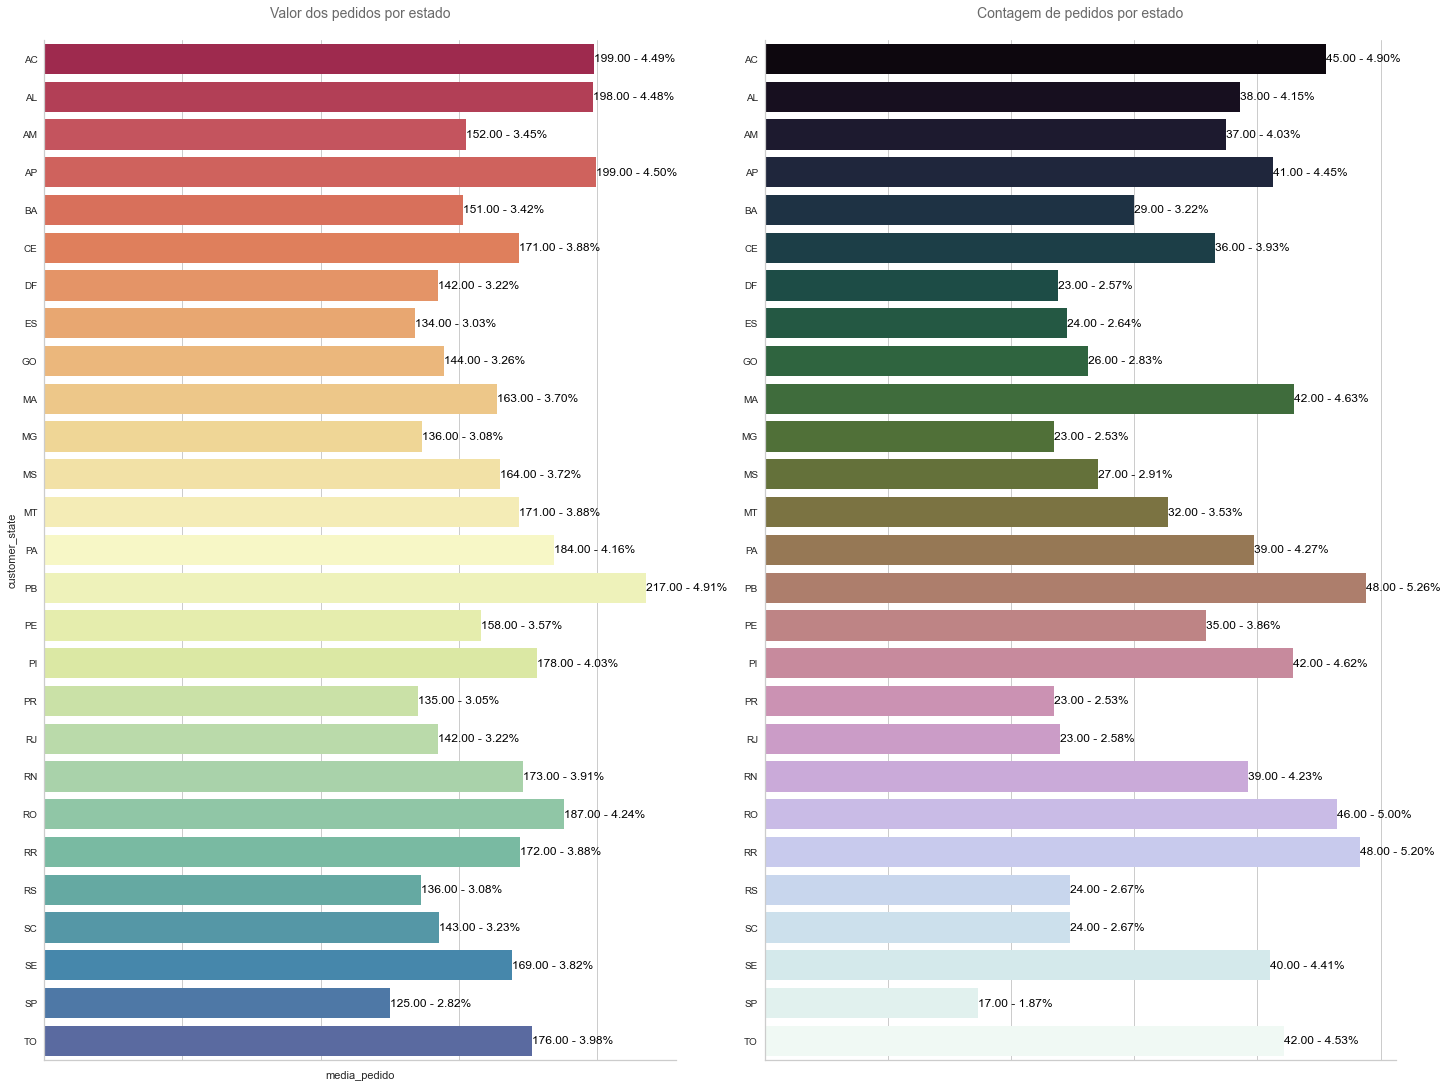

In [140]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

bar_plot(df_customer_grouped, 
         y='customer_state', 
         x='media_pedido',
         ax=ax1, 
         orient_horizontal = False,
         palette='Spectral', 
         title='Valor dos pedidos por estado')
ax3.set_ylabel('')
ax3.set_xlabel('')

## Gráfico 3
bar_plot(df_customer_grouped, 
         y='customer_state', 
         x='media_frete',
         ax=ax2, 
         orient_horizontal = False,
         palette='cubehelix', 
         title='Contagem de pedidos por estado')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.show()

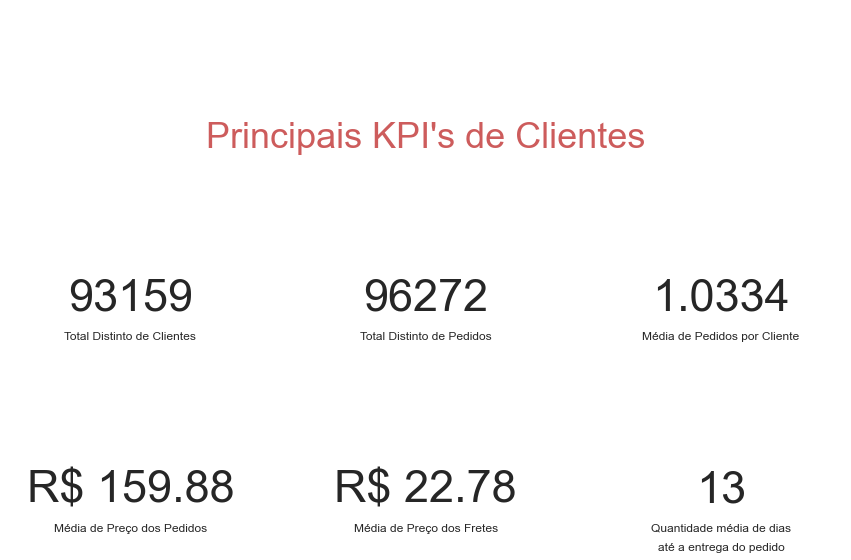

In [141]:
## Objetos referentes as figuras
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Titulo
axs[0, 1].text(0.50, 0.12, "Principais KPI's de Clientes", fontsize=36, ha='center', color="indianred")
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[0, 2].axis('off')

axs[1, 0].text(0.50, 0.30, f'{round(df_data["customer_unique_id"].nunique(), 2)}', fontsize=45, ha='center')
axs[1, 0].text(0.50, 0.12, 'Total Distinto de Clientes', fontsize=12, ha='center')
axs[1, 0].axis('off')

axs[1, 1].text(0.50, 0.30, f'{round(df_data["order_id"].nunique(), 2)}', fontsize=45, ha='center')
axs[1, 1].text(0.50, 0.12, 'Total Distinto de Pedidos', fontsize=12, ha='center')
axs[1, 1].axis('off')

axs[1, 2].text(0.50, 0.30, f'{round(((df_data["order_id"].nunique())/ (df_data["customer_unique_id"].nunique())), 4)}', fontsize=45, ha='center')
axs[1, 2].text(0.50, 0.12, 'Média de Pedidos por Cliente', fontsize=12, ha='center')
axs[1, 2].axis('off')

axs[2, 0].text(0.50, 0.30, f'R$ {round(df_data["total_payment"].mean(), 2)}', fontsize=45, ha='center')
axs[2, 0].text(0.50, 0.12, 'Média de Preço dos Pedidos', fontsize=12, ha='center')
axs[2, 0].axis('off')

axs[2, 1].text(0.50, 0.30, f'R$ {round(df_data["total_freight_value"].mean(), 2)}', fontsize=45, ha='center')
axs[2, 1].text(0.50, 0.12, 'Média de Preço dos Fretes', fontsize=12, ha='center')
axs[2, 1].axis('off')

axs[2, 2].text(0.50, 0.30, f'{round(df_data["diff_days_customer_purchase"].mean())}', fontsize=45, ha='center')
axs[2, 2].text(0.50, 0.12, 'Quantidade média de dias', fontsize=12, ha='center')
axs[2, 2].text(0.50, 0.00, 'até a entrega do pedido', fontsize=12, ha='center')
axs[2, 2].axis('off')

plt.show()

<a id = '6'></a>
<h3>6. Realizando o tratamento das variaveis categoricas</h3>

<a id = '61'></a>
<h4>6.1. Analisando os dados dos parametros selecionados</h4>

In [142]:
## Distribuição de frequência
frequency_distribution(df_data, 'customer_city')

,Frequencia Absoluta,Frequencia Relativa
customer_city,,
sao paulo,15019,15.600590
rio de janeiro,6594,6.849344
belo horizonte,2687,2.791050
brasilia,2068,2.148080
curitiba,1486,1.543543
...,...,...
humildes,1,0.001039
rio grande do piaui,1,0.001039
iaras,1,0.001039


In [143]:
## Distribuição de frequência
frequency_distribution(df_data, 'customer_state')

,Frequencia Absoluta,Frequencia Relativa
customer_state,,
SP,40422,41.987286
RJ,12331,12.808501
MG,11325,11.763545
RS,5325,5.531203
PR,4912,5.102210
SC,3535,3.671888
BA,3252,3.377929
DF,2077,2.157429
ES,1989,2.066021


In [144]:
## Distribuição de frequência
frequency_distribution(df_data, 'order_status')

,Frequencia Absoluta,Frequencia Relativa
order_status,,
delivered,96266,99.993768
canceled,6,0.006232


In [145]:
## Distribuição de frequência
frequency_distribution(df_data, 'payment_sequential_categ')

,Frequencia Absoluta,Frequencia Relativa
payment_sequential_categ,,
apenas_1,93325,96.938882
maior_de_1,2947,3.061118


<a id ='62'></a>
<h4>6.2. Aplicando o One-Hot-Encondig</h4>

Podemos identificar que a variável _customer_city_ é muito puverizada no dataset, isto é, existem muitos registros dessa variável, e aparentemente não acrescentaria muito na análise. Uma outra muito pulverizada é a _customer_state_, contudo, para essa variável criaremos outra que corresponderá a região do cliente, nesse caso, se o cliente for de SP, então a sua região será a Sudeste, dessa forma diminuimos essa pulverização de dados.

In [146]:
def region(state):
    if state in ['AC', 'RO', 'AM', 'PA', 'RR', 'AP', 'TO']:
        return "Norte"
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return "Nordeste"
    elif state in ['MT', 'GO', 'MS', 'DF']:
        return "Centro_Oeste"
    elif state in ['MG', 'ES', 'RJ', 'SP']:
        return "Sudeste"
    else:
        return "Sul"
    
df_data["customer_region"] = df_data["customer_state"].apply(lambda state: region(state))

In [147]:
## Distribuição de frequência
frequency_distribution(df_data, 'customer_region')

,Frequencia Absoluta,Frequencia Relativa
customer_region,,
Sudeste,66067,68.625353
Sul,13772,14.305302
Nordeste,9029,9.378636
Centro_Oeste,5610,5.827239
Norte,1794,1.863470


In [148]:
columns = ["customer_region", "payment_sequential_categ", "order_status"]

In [149]:
# Criando o objeto onehotencoder
one_hot_encoding = OneHotEncoder()

In [150]:
# Criando um dataframe com as colunas
df_enc = pd.DataFrame(one_hot_encoding.fit_transform(df_data[columns]).toarray())

# Definindo o nome das colunas captando o nome das features
df_enc.columns = one_hot_encoding.get_feature_names(columns)

# Remover do dataframe original a coluna que esta sendo usada no processo
df_aux = df_data.drop(columns, axis = 1)
df_aux = df_data.drop(['customer_city', 'customer_state'], axis = 1)

# Realizar um concat
df_data_treat = pd.concat([df_aux, df_enc], axis = 1)

In [151]:
## Verificando os dados
df_data_treat.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_hours_purchase_approved,diff_hours_carries_purchase,diff_hours_customer_carrier,diff_days_customer_purchase,diff_days_customer_estimated,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,payment_installments,payment_sequential,payment_sequential_categ,count_order_item_id,count_product_id,count_seller_id,total_price,total_freight_value,total_payment,customer_region,customer_region_Centro_Oeste,customer_region_Nordeste,customer_region_Norte,customer_region_Sudeste,customer_region_Sul,payment_sequential_categ_apenas_1,payment_sequential_categ_maior_de_1,order_status_canceled,order_status_delivered
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,0.276944,163.706111,47.793889,8.812500,10.558623,0.0,146.87,0.0,0,0.0,2,1,apenas_1,1,1,1,124.99,21.88,146.87,Sudeste,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,0.168889,68.443056,331.438889,16.661748,7.471308,0.0,335.48,0.0,0,0.0,8,1,apenas_1,1,1,1,289.00,46.48,335.48,Sudeste,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,24.190278,550.387500,75.464167,26.077153,-1.749201,0.0,157.73,0.0,0,0.0,7,1,apenas_1,1,1,1,139.94,17.79,157.73,Sudeste,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.378056,343.267778,16.695278,14.998461,12.330266,0.0,173.30,0.0,0,0.0,1,1,apenas_1,1,1,1,149.94,23.36,173.30,Sudeste,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,0.310833,29.408333,245.663333,11.461319,5.127917,0.0,252.25,0.0,0,0.0,8,1,apenas_1,1,1,1,230.00,22.25,252.25,Sudeste,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


<a id = '7'></a>
<h3>7. Seleção de Dados e Variáveis</h3>

<p>Temos alguns hiperparâmetros com valores categoricos, sendo assim precisaremos submeter tais dados aos processos de <i>Label Encoding</i> ou <i>One hot Encoding</i>

Para fins de análise foi estabelecido uma data de corte de **18 meses**, contidos no período **Janeiro/2017** até **Junho/2018**

A partir desse momento os dados serão agrupados por clientes

In [152]:
## Selecionando os dados no período de corte
df_data_treat = df_data_treat.loc[(df_data_treat['order_purchase_timestamp'] >= '2017-01-01') & (df_data_treat['order_purchase_timestamp'] < '2018-07-01')]

In [153]:
## Agrupando os dados por conta/ cliente
df_data_treat_grouped = df_data_treat.groupby(["customer_unique_id"]).agg({'diff_hours_purchase_approved': 'mean',
                                                                           'diff_hours_carries_purchase': 'mean',
                                                                           'diff_hours_customer_carrier': 'mean',
                                                                           'diff_days_customer_purchase': 'mean',
                                                                           'diff_days_customer_estimated': 'mean',
                                                                           'payment_type_boleto': 'sum',
                                                                           'payment_type_credit_card': 'sum',
                                                                           'payment_type_debit_card': 'sum',
                                                                           'payment_type_not_defined': 'sum',
                                                                           'payment_type_voucher': 'sum',
                                                                           'payment_installments': 'mean',
                                                                           'count_order_item_id': 'sum',
                                                                           'count_product_id': 'sum',
                                                                           'count_seller_id': 'sum',
                                                                           'total_price': 'sum',
                                                                           'total_freight_value': 'sum',
                                                                           'total_payment': 'sum',
                                                                           'payment_sequential_categ_apenas_1': 'sum',
                                                                           'payment_sequential_categ_maior_de_1': 'sum',
                                                                           'order_status_canceled': 'sum',
                                                                           'order_status_delivered': 'sum',
                                                                            }).reset_index()

In [154]:
## Setando apenas as variaveis numericas no dataframe final
df_data_treat_final = df_data_treat_grouped.select_dtypes(include = np.number)

In [155]:
## Visualizando os primeiros dados
df_data_treat_final.head()

,diff_hours_purchase_approved,diff_hours_carries_purchase,diff_hours_customer_carrier,diff_days_customer_purchase,diff_days_customer_estimated,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,payment_installments,count_order_item_id,count_product_id,count_seller_id,total_price,total_freight_value,total_payment,payment_sequential_categ_apenas_1,payment_sequential_categ_maior_de_1,order_status_canceled,order_status_delivered
0,0.247500,45.359167,108.510278,6.411227,4.132905,0.0,141.90,0.0,0,0.0,8.0,1,1,1,129.90,12.00,141.90,1.0,0.0,0.0,1.0
1,7.238056,49.109167,29.745000,3.285590,4.248125,0.0,27.19,0.0,0,0.0,1.0,1,1,1,18.90,8.29,27.19,1.0,0.0,0.0,1.0
2,0.000000,63.890833,553.671389,25.731759,1.389734,0.0,86.22,0.0,0,0.0,8.0,1,1,1,69.00,17.22,86.22,1.0,0.0,0.0,1.0
3,0.326667,23.643889,457.246111,20.037083,11.108970,0.0,43.62,0.0,0,0.0,4.0,1,1,1,25.99,17.63,43.62,1.0,0.0,0.0,1.0
4,0.352778,48.107778,267.279444,13.141134,7.035463,0.0,196.89,0.0,0,0.0,6.0,1,1,1,180.00,16.89,196.89,1.0,0.0,0.0,1.0


Uma vez criada a coluna com os dados das regiões, será aplicado o tratamento onehot encoder, que basicamente transforma as observações categóricas em colunas no dataframe

<a id ='71'></a>
<h4>7.1. Correlação dos dados</h4>

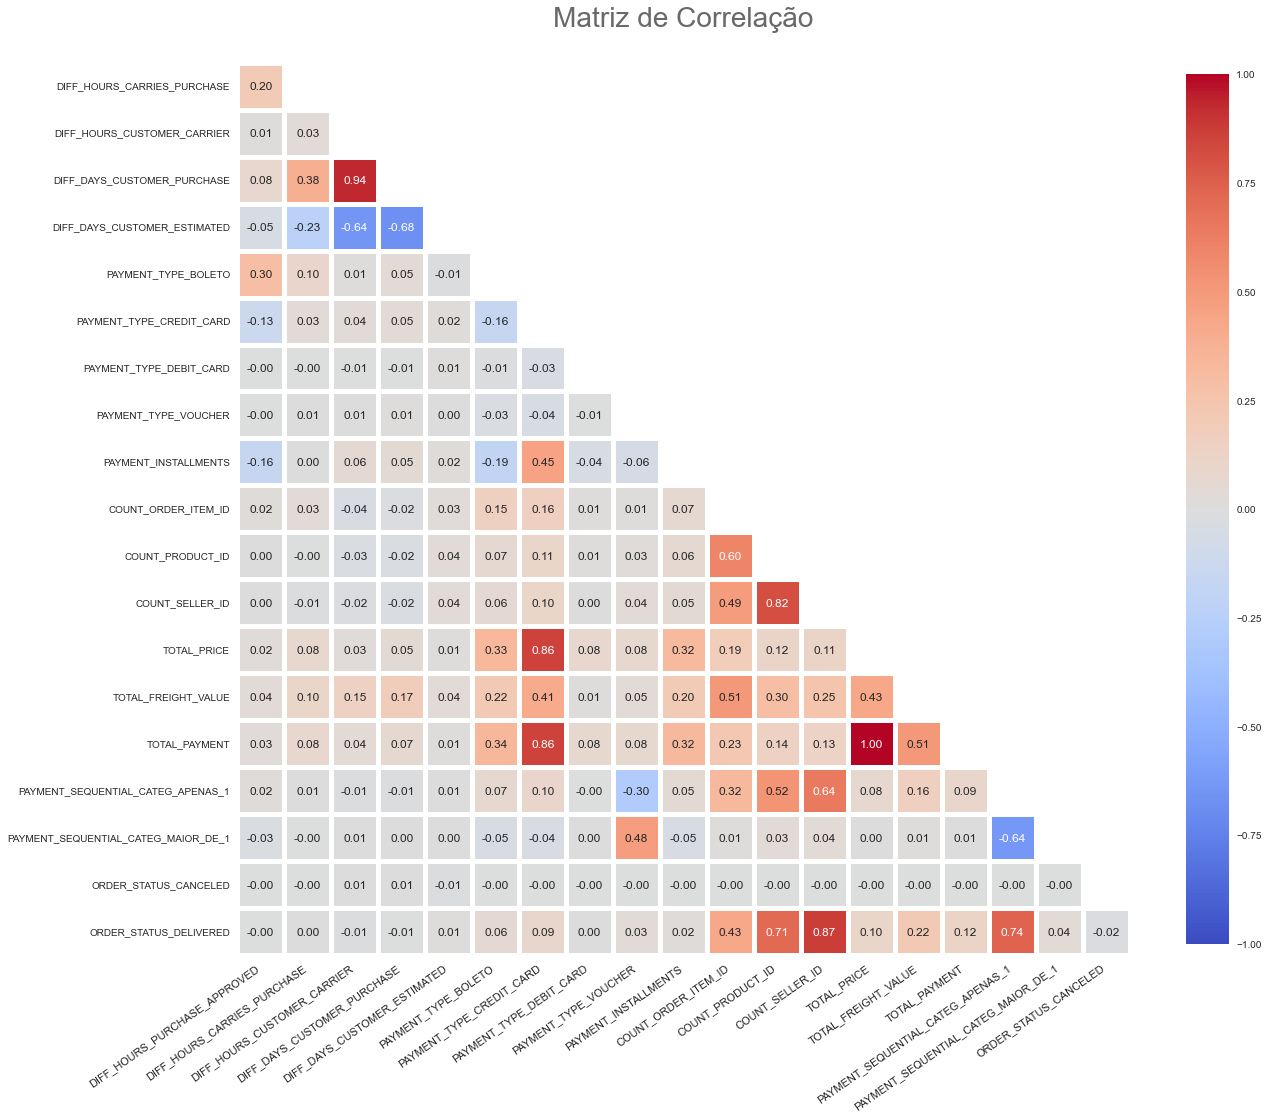

In [156]:
# Verificando a correlacao das variaveis
df_corr = df_data_treat_final.drop(['payment_type_not_defined'], axis=1).corr()

fig, ax = plt.subplots(figsize=(20, 20))

heatmap_plot(df_corr=df_corr, ax=ax, title="Matriz de Correlação", title_size=28)

Analisando os dados das correlações temos:

- Uma correlação forte entre **_total_price_** e **_total_payment_** indicando que uma dessas variáveis deve ser removida, dado que sua correlação é perfeita;
- Uma correlação forte entre **_diff_days_customer_purchase_** e **_diff_hours_customer_carrier_** indicando uma relação de atraso na entrega ao cliente, associado ao tempo de entrega da transportadora;
- Existe uma correlação levemente forte entre **_freight_value_** e **_count_order_item_id_** indicando uma relação entre valor do frete e quantidade de itens em um pedido
- Existe uma correlação significamente forte entre **_order_status_delivered_** e **_payment_sequential_categ_apenas_1_** indicando uma forte relação entre pedidos que foram entregas com apenas um tipo de pagamento

In [157]:
## Removendo colunas desnecessarias
df_data_treat_final = df_data_treat_final.drop(['total_price'], axis=1)

<a id = '8'></a>
<h3>8. Submetendo os dados ao modelo</h3>


<a id ='81'></a>
<h4>8.1. Padronizando os dados</h4>

In [158]:
# Instanciar o objeto referente a normalizacao/ padronizacao dos dados
scaler = StandardScaler()

# Normalizar os Dados
scaled_features = scaler.fit_transform(df_data_treat_final)

<a id ='82'></a>
<h4>8.2. Analisando o número de clusters</h4>

<a id ='821'></a>
<h5>8.2.1 Método Elbow</h5>

O método elbow é conhecido como método do cotovelo. Basicamente o que o método faz é testar a variância dos dados em relação ao número de clusters. 
Podemos ver esse “cotovelo” quando plotamos seus resultados em um gráfico.

A partir do valor indicado pelo “cotovelo” no gráfico significa que não existe ganho em relação ao aumento de clusters.

In [159]:
# Lista que contera os valores referente a inercia do modelo k-means
lst_wcss = []

# Laco para captar a inercia a cada cluster definido
for i in range(1, 11):
    # Objeto Kmeans
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    
    # Submetendo dados ao modelo
    kmeans.fit(scaled_features)
    
    # Armazenando a inercia na lista
    lst_wcss.append(kmeans.inertia_)

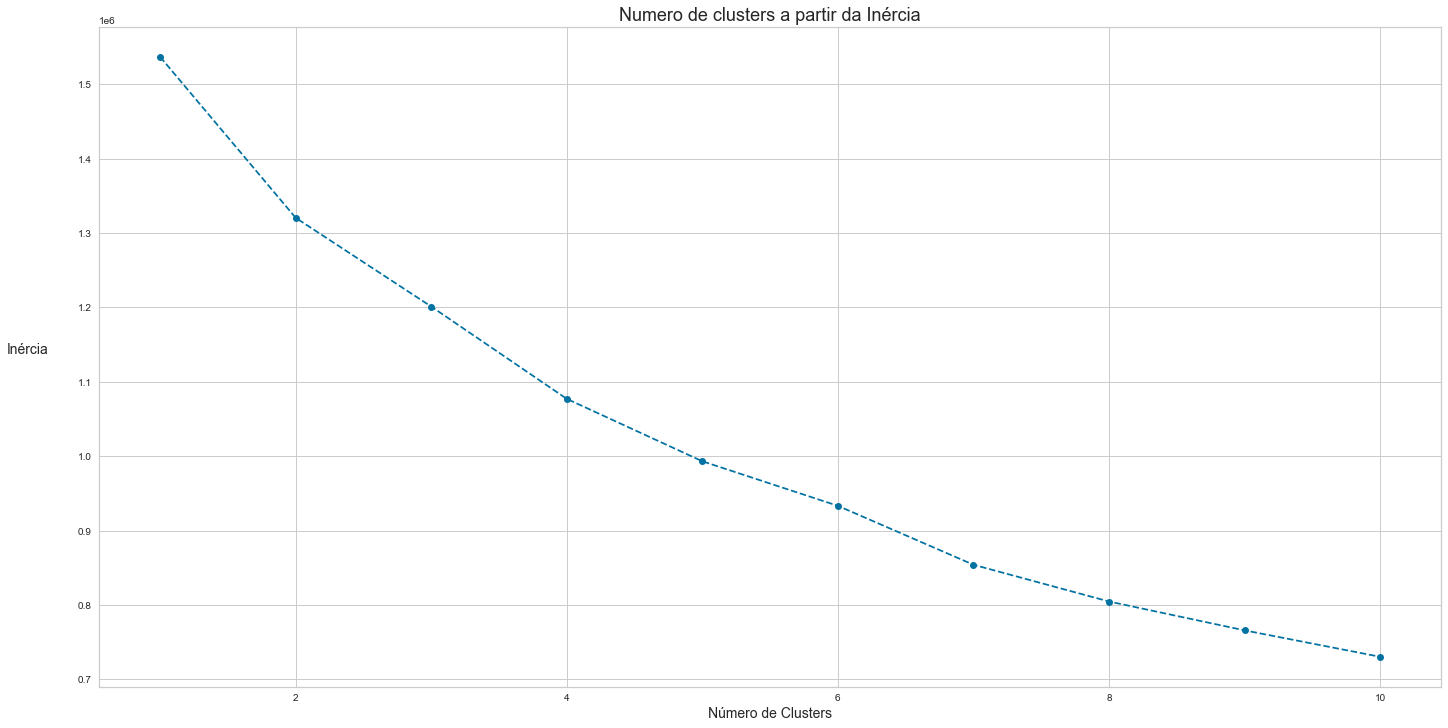

In [160]:
# Tamanho do gráfico
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

# Objeto que corresponde ao gráfico
plt.plot(range(1, 11), lst_wcss, marker = 'o', linestyle = '--')

# Informações do gráfico
plt.xlabel('Número de Clusters', 
           fontsize = 14)

plt.ylabel('Inércia', 
           labelpad = 50, 
           rotation = 0, 
           fontsize = 14)

## Titulo
plt.title('Numero de clusters a partir da Inércia', fontsize = 18)

# Exibir gráfico
plt.show()

<a id ='822'></a>
<h5>8.2.2 Método Davies Bouldin</h5>

In [161]:
## Função de apoio
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center, random_state = 42)
    model = kmeans.fit_predict(data)    
    score = davies_bouldin_score(data, model)    
    return score

In [162]:
## Processando as métricas
scores = []
centers = list(range(2,10))
for center in centers:
    scores.append(get_kmeans_score(scaled_features, center))   

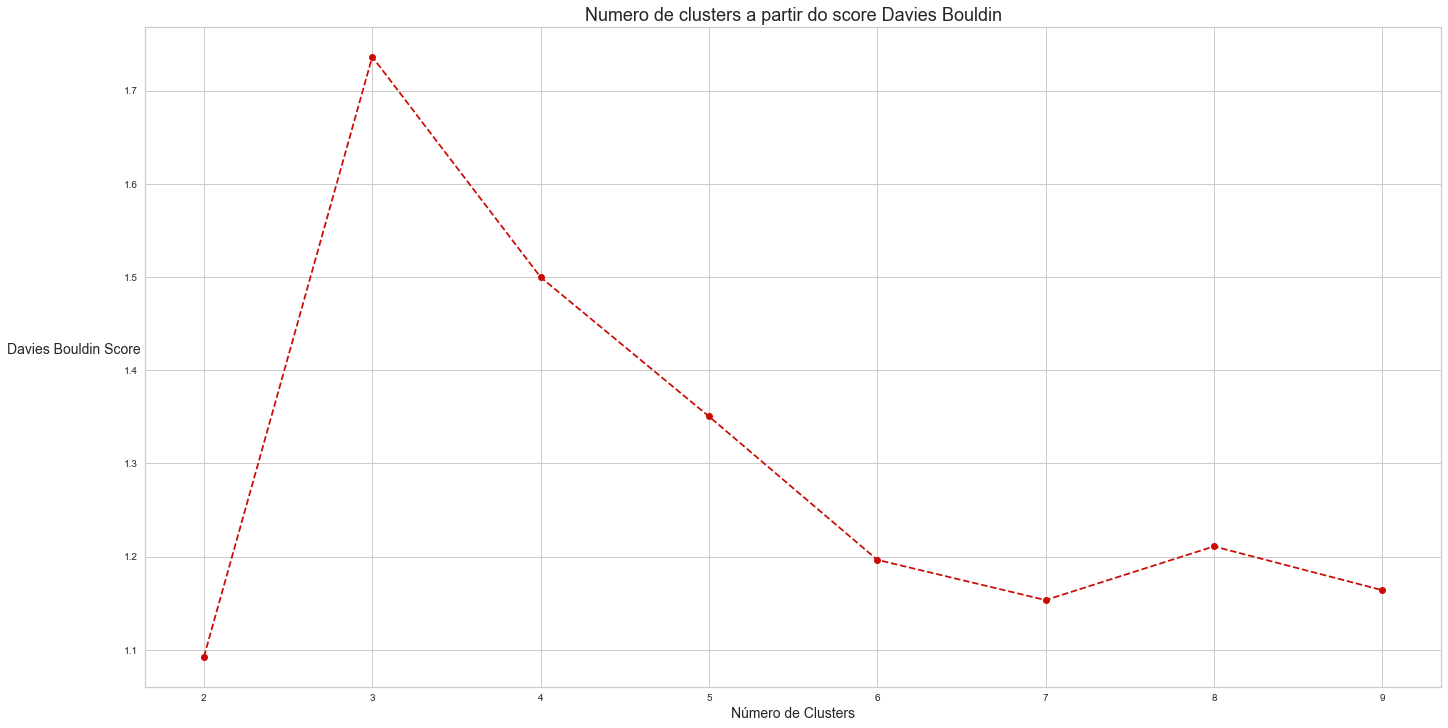

In [163]:
# Tamanho do gráfico
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

# Objeto que corresponde ao gráfico
plt.plot(centers, scores, marker = 'o', linestyle = '--', color='r')

# Informações do gráfico
plt.xlabel('Número de Clusters', 
           fontsize = 14)

plt.ylabel('Davies Bouldin Score', 
           labelpad = 50, 
           rotation = 0, 
           fontsize = 14)

## Titulo
plt.title('Numero de clusters a partir do score Davies Bouldin', fontsize = 18)

# Exibir gráfico
plt.show()

<a id ='823'></a>
<h5>8.2.3 Biblioteca KneedLocator</h5>

<p>O Grafico nos mostrou que o numero adequando de cluster para o algoritmos Kmeans esta entre 5 e 7. A seguir veremos como ficou o score da silhueta para cada quantidade de clusters</p>

In [164]:
# Executando a funcao que nos mostra a quantidade adequada de clusters
el = KneeLocator(range(1, 11), 
                 lst_wcss, curve = "convex", 
                 direction = "decreasing")

print("A quantidade adequada de clusters eh: ", el.elbow)

A quantidade adequada de clusters eh:  4


https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

<a id ='824'></a>
<h5>8.2.4 Biblioteca KElbowVisualizer</h5>

<a id ='8241'></a>
<h6>8.2.4.1 Elbow Method</h6>

O método elbow é conhecido como método do cotovelo. Basicamente o que o método faz é testar a variância dos dados em relação ao número de clusters. 
Podemos ver esse “cotovelo” quando plotamos seus resultados em um gráfico.

A partir do valor indicado pelo “cotovelo” no gráfico significa que não existe ganho em relação ao aumento de clusters.

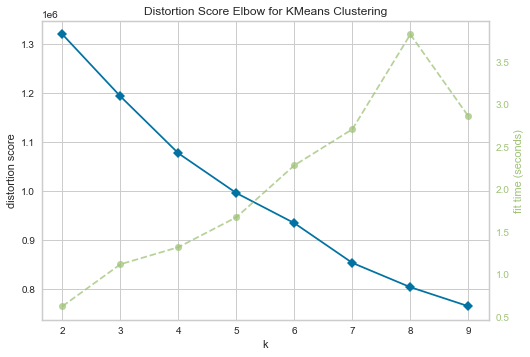

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [165]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(2,10), 
                              timings= True, 
                              locate_elbow=True)

visualizer.fit(scaled_features)
visualizer.show()

<a id ='8242'></a>
<h6>8.2.4.2 Calinski Harabasz</h6>

O Índice Calinski-Harabasz (CH) (introduzido por Calinski e Harabasz em 1974) pode ser usado para avaliar o modelo quando os rótulos verdadeiros não são conhecidos, onde a validação de quão bem o agrupamento foi feito é feita usando quantidades e recursos inerentes ao conjunto de dados. O índice CH (também conhecido como critério de razão de variância ) é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Aqui, a coesão é estimada com base nas distâncias dos pontos de dados em um cluster ao seu centróide do cluster e a separação é baseada na distância dos centróides do cluster do centróide global. O índice CH tem uma forma de (a. Separação) / (b. Coesão), onde aeb são pesos. 


Um **valor mais alto do índice CH significa que os clusters são densos e bem separados**, embora não haja um valor de corte "aceitável". Precisamos escolher aquela solução que fornece um pico ou pelo menos uma curva abrupta no gráfico de linha dos índices CH. Por outro lado, se a linha for lisa (horizontal ou ascendente ou descendente), então não há razão para preferir uma solução a outras. 


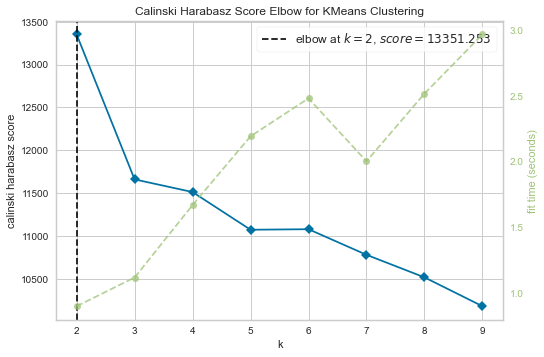

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [166]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),metric='calinski_harabasz', timings= True, locate_elbow=True)
visualizer.fit(scaled_features)
visualizer.show()  

<a id ='8243'></a>
<h6>8.2.4.3 Silhouette Score</h6>

Dentre as abordagens existentes para auxiliar na decisão do número de grupos, foi utilizado o método Silhueta que auxilia na escolha de um número ótimo de grupos, avaliando os particionamentos encontrados, e permite visualizar graficamente os agrupamentos.

A silhueta é um gráfico composto por um valor de silhueta que reflete a qualidade da alocação dos objetos no grupos.
A seguir temos uma tabela onde é possível identificar, pelo valor da silhueta, a situação dos cluster obtidos

|CS(i) |Interpretação sugerida|
|---|---|
|0.71 − 1.00| Grupos descobertos possuem uma estrutura muito robusta|
|0.51 − 0.70| Grupos possuem uma estrutura razoável|
|0.26 − 0.50| Os grupos encontrados possuem uma estrutura fraca e pode ser artificial. É aconselhável tentar outros métodos sobre o conjunto de dados|
|≤ 0.25| Nenhuma estrutura foi descoberta

Link: http://www.dsr.inpe.br/sbsr2015/files/p0903.pdf

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(2,10), 
                              metric='silhouette', 
                              timings= True, 
                              locate_elbow=True)

visualizer.fit(scaled_features)
visualizer.show()

<a id ='83'></a>
<h4>8.3. Definindo o Modelo</h4>

<a id ='831'></a>
<h5>8.3.1 Estatísticas obtidas</h5>

Com 3 ou 5 clusters teremos as estatísticas a seguir

<a id ='8311'></a>
<h6>8.3.1.1 (3 x 4 x 5) Clusters</h6>

In [167]:
## Definindo o modelo e seus hiperparâmetros
kmeans_cluster_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42).fit(scaled_features)
## Labels geradas
labels_3_clusters = kmeans_cluster_3.labels_

In [168]:
## Calculando as estatísticas
cluster_3_calinski = metrics.calinski_harabasz_score(scaled_features, labels_3_clusters)
cluster_3_bouldin = metrics.davies_bouldin_score(scaled_features, labels_3_clusters)
cluster_3_inertia = kmeans_cluster_3.inertia_
cluster_3_silhouette = metrics.silhouette_score(scaled_features, labels_3_clusters)

In [169]:
## Definindo o modelo e seus hiperparâmetros
kmeans_cluster_4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42).fit(scaled_features)
## Labels geradas
labels_4_clusters = kmeans_cluster_4.labels_

In [170]:
## Calculando as estatísticas
cluster_4_calinski = metrics.calinski_harabasz_score(scaled_features, labels_4_clusters)
cluster_4_bouldin = metrics.davies_bouldin_score(scaled_features, labels_4_clusters)
cluster_4_inertia = kmeans_cluster_4.inertia_
cluster_4_silhouette = metrics.silhouette_score(scaled_features, labels_4_clusters)

In [171]:
## Definindo o modelo e seus hiperparâmetros
kmeans_cluster_5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42).fit(scaled_features)
## Labels geradas
labels_5_clusters = kmeans_cluster_5.labels_

In [172]:
## Calculando as estatísticas
cluster_5_calinski = metrics.calinski_harabasz_score(scaled_features, labels_5_clusters)
cluster_5_bouldin = metrics.davies_bouldin_score(scaled_features, labels_5_clusters)
cluster_5_inertia = kmeans_cluster_5.inertia_
cluster_5_silhouette = metrics.silhouette_score(scaled_features, labels_5_clusters)

In [173]:
print()
print('\t\tComparando as métricas obtidas a partir do número de clusters.')
dct_model_comparition  = {'3 Clusters ': 
                                        {'Indíce Calinski-Harabasz': cluster_3_calinski ,
                                         'Indíce Davies-Bouldin': cluster_3_bouldin,
                                         'Elbow Method Inertia': cluster_3_inertia ,
                                         'Silouette Score)': cluster_3_silhouette,},
                          '4 Clusters ':
                                        {'Indíce Calinski-Harabasz': cluster_4_calinski ,
                                         'Indíce Davies-Bouldin': cluster_4_bouldin,
                                         'Elbow Method Inertia': cluster_4_inertia ,
                                         'Silouette Score)': cluster_4_silhouette,},
                          '5 Clusters ':
                                        {'Indíce Calinski-Harabasz': cluster_5_calinski ,
                                         'Indíce Davies-Bouldin': cluster_5_bouldin,
                                         'Elbow Method Inertia': cluster_5_inertia ,
                                         'Silouette Score)': cluster_5_silhouette,}
                         }

## Dataframe com os dados
df_model_comparission = pd.DataFrame(dct_model_comparition).T
## Mostrar Dados
df_model_comparission


		Comparando as métricas obtidas a partir do número de clusters.


,Indíce Calinski-Harabasz,Indíce Davies-Bouldin,Elbow Method Inertia,Silouette Score)
3 Clusters,11304.901985,1.736266,1.201285e+06,0.373224
4 Clusters,11512.198274,1.499755,1.077159e+06,0.393481
5 Clusters,11072.608169,1.350356,9.932266e+05,0.356134


Percebe-se pelas estatíticas Davies-Bouldin e Silhoutte Score que a quantidade de clusters igual a 3 acaba sendo a mais adequada.
A seguir será feito uma plotagem analisando o **_Silhouette Score_** de cada cluster gerado.


range_n_clusters = [2, 3, 4, 5]
X = scaled_features

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette score para n clusters.")
    ax1.set_xlabel("Valor do Silhouette Score")
    ax1.set_ylabel("Cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualização dos dados clusterizados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Analise do numero de cluster a partir do Silhouette Score para {n_clusters} clusters", fontsize=14, fontweight="bold")

plt.show()

<a id ='832'></a>
<h5>8.3.2 Definindo Modelo Final</h5>

Até esse momento as estatisticas listadas anteriormente, mostram que o número mais adequado de clusters é 3.

In [180]:
## Definindo o modelo e seus hiperparâmetros
kmeans_model = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
## Realizando o fit e gerando os dados
kmeans_model.fit(scaled_features)
## Incluindo os dados no dataframe
df_data_treat_final['Cluster_3'] = kmeans_model.predict(scaled_features)

In [181]:
## Visualizando os dados
df_data_treat_final.head()

,diff_hours_purchase_approved,diff_hours_carries_purchase,diff_hours_customer_carrier,diff_days_customer_purchase,diff_days_customer_estimated,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,payment_installments,count_order_item_id,count_product_id,count_seller_id,total_freight_value,total_payment,payment_sequential_categ_apenas_1,payment_sequential_categ_maior_de_1,order_status_canceled,order_status_delivered,Cluster_3
0,0.247500,45.359167,108.510278,6.411227,4.132905,0.0,141.90,0.0,0,0.0,8.0,1,1,1,12.00,141.90,1.0,0.0,0.0,1.0,0
1,7.238056,49.109167,29.745000,3.285590,4.248125,0.0,27.19,0.0,0,0.0,1.0,1,1,1,8.29,27.19,1.0,0.0,0.0,1.0,0
2,0.000000,63.890833,553.671389,25.731759,1.389734,0.0,86.22,0.0,0,0.0,8.0,1,1,1,17.22,86.22,1.0,0.0,0.0,1.0,1
3,0.326667,23.643889,457.246111,20.037083,11.108970,0.0,43.62,0.0,0,0.0,4.0,1,1,1,17.63,43.62,1.0,0.0,0.0,1.0,0
4,0.352778,48.107778,267.279444,13.141134,7.035463,0.0,196.89,0.0,0,0.0,6.0,1,1,1,16.89,196.89,1.0,0.0,0.0,1.0,0


In [190]:
## Analisando Cluster 1
df_data_treat_final[df_data_treat_final['Cluster_3'] == 0].describe().T[['count', 'mean', '50%', '75%']]

,count,mean,50%,75%
diff_hours_purchase_approved,64775.0,9.554712,0.337778,12.434306
diff_hours_carries_purchase,64775.0,66.716350,50.833333,92.141250
diff_hours_customer_carrier,64775.0,179.120738,165.902500,244.480833
diff_days_customer_purchase,64775.0,10.243212,9.585139,13.559300
diff_days_customer_estimated,64775.0,13.647810,13.136146,17.325272
payment_type_boleto,64775.0,23.649635,0.000000,0.000000
payment_type_credit_card,64775.0,95.428476,71.050000,136.050000
payment_type_debit_card,64775.0,1.463693,0.000000,0.000000
payment_type_not_defined,64775.0,0.000000,0.000000,0.000000
payment_type_voucher,64775.0,3.447279,0.000000,0.000000


<p style="font-size: 2rem; color: #B0C4DE">Cluster 1 !!!</p>

- Cluster com mais clientes;
- Entregas demoram em média 10 dias
- Pagam em média 123.98 por pedido;
- Pagam em média 19.04 no frete;
- Em média fazem pedidos com 1 item;
- Em média parcelam as compras em 2 vezes ou mais
- Usam mais cartão de crédito, em seguida voucher e boleto

In [191]:
df_data_treat_final[df_data_treat_final['Cluster_3'] == 1].describe().T[['count', 'mean', '50%', '75%']]

,count,mean,50%,75%
diff_hours_purchase_approved,13472.0,13.124923,0.398889,23.268681
diff_hours_carries_purchase,13472.0,135.594931,88.091944,159.806250
diff_hours_customer_carrier,13472.0,523.560562,486.325139,655.536250
diff_days_customer_purchase,13472.0,27.464812,25.282078,32.195738
diff_days_customer_estimated,13472.0,0.265073,1.767014,8.656733
payment_type_boleto,13472.0,52.372372,0.000000,0.000000
payment_type_credit_card,13472.0,271.954070,143.330000,315.930000
payment_type_debit_card,13472.0,1.725718,0.000000,0.000000
payment_type_not_defined,13472.0,0.000000,0.000000,0.000000
payment_type_voucher,13472.0,4.276750,0.000000,0.000000


<p style="font-size: 2rem; color: #CD5C5C">Cluster 2 !!!</p>

- Segundo maior cluster
- Demora em média 27 dias para entregar
- Usam mais cartão de crédito, boleto e voucher
- Em média parcelam as compras em 4 vezes ou mais
- Os pedidos custam em média 330.32

In [192]:
df_data_treat_final[df_data_treat_final['Cluster_3'] == 2].describe().T[['count', 'mean', '50%', '75%']]

,count,mean,50%,75%
diff_hours_purchase_approved,2650.0,10.039376,0.478611,14.585556
diff_hours_carries_purchase,2650.0,79.779710,64.554653,100.043854
diff_hours_customer_carrier,2650.0,221.551108,184.583889,286.647882
diff_days_customer_purchase,2650.0,12.555451,11.184876,15.699213
diff_days_customer_estimated,2650.0,12.491590,12.622613,16.391091
payment_type_boleto,2650.0,70.756396,0.000000,0.000000
payment_type_credit_card,2650.0,243.587857,181.985000,314.855000
payment_type_debit_card,2650.0,2.027200,0.000000,0.000000
payment_type_not_defined,2650.0,0.000000,0.000000,0.000000
payment_type_voucher,2650.0,9.060868,0.000000,0.000000


<p style="font-size: 2rem; color: #FFD700">Cluster 3 !!!</p>

- Terceiro maior cluster
- Demora em média 12 dias para entregar
- Usam mais cartão de crédito, voucher e boleto
- Em média parcelam as compras em 4 vezes ou mais
- Os pedidos no geral tem mais de 1 item
- Os pedidos em média contemplam mais de um vendedor
- Em relação aos outros cluster, é mais comum os clientes pagarem os pedidos com apenas 1 método de pagamento
- Os pedidos custam em média 330.32

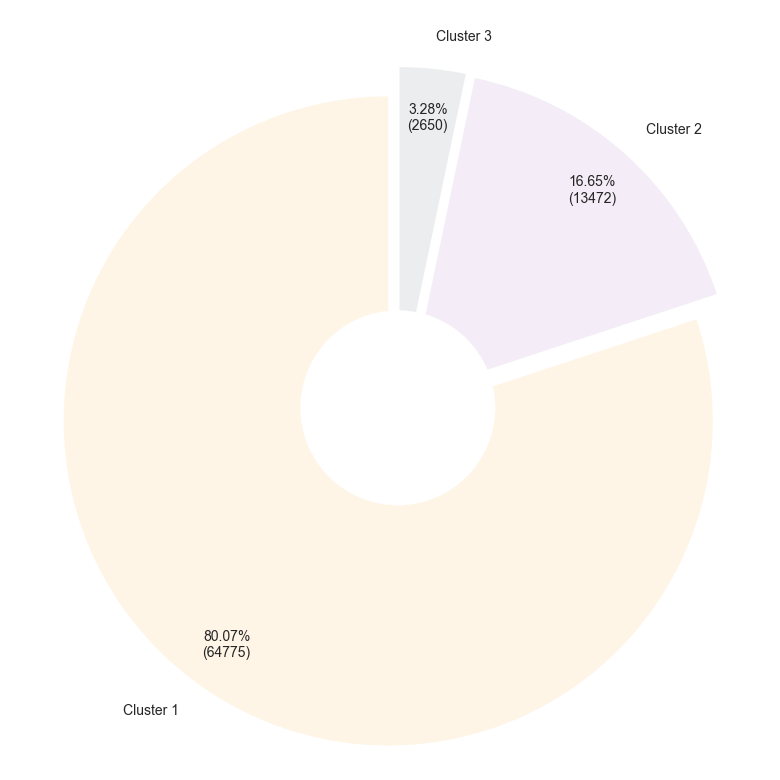

In [189]:
fig = plt.figure(constrained_layout=True, figsize=(11, 11))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

## Gráfico 1
colors = ['#FEF5E7','#F4ECF7' , '#EBEDEF']
label_names = ['Cluster 1', 'Cluster 2', 'Cluster 3']
pie_plot(df_data_treat_final, 
         col='Cluster_3', 
         ax=ax1, 
         label_names=label_names, 
         colors=colors,
         circle_radius=0.3,
         title='', 
         text=f'')